<a href="https://colab.research.google.com/github/mission8th/source_code/blob/main/Sig_travel_retry2_Github%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [620]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [621]:
import numpy as np
import pandas as pd
import os
import pickle
import gc
import re

import matplotlib.pyplot as plt
import seaborn as sns
import numpy.random as random
from pandas import Series, DataFrame

import lightgbm as lgb
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.tree import  DecisionTreeRegressor

#ÂàÜÂ∏ÉÁ¢∫Ë™ç
!pip install ydata_profiling
import ydata_profiling as pdp

#ÂâçÂá¶ÁêÜ
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder,OneHotEncoder,OrdinalEncoder
#„É¢„Éá„É™„É≥„Ç∞
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold,StratifiedGroupKFold
from sklearn.metrics import f1_score,recall_score, precision_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [622]:
dfff_train = pd.read_csv("/content/drive/MyDrive/SIGNATE-travel/train.csv")
dfff_test = pd.read_csv("/content/drive/MyDrive/SIGNATE-travel/test.csv")

dff_train = dfff_train.copy()
dff_test = dfff_test.copy()

In [623]:
#Â≠¶Áøí„Éá„Éº„Çø„Å®„ÉÜ„Çπ„Éà„Éá„Éº„Çø„Çí‰∏ÄÊó¶ÁµêÂêà„Åó„Å¶„Åä„Åè
df_all = pd.concat([dff_train, dff_test], keys=["train","test"]).reset_index(level =0)

In [624]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f}MB".format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
             pass

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df

In [625]:
#„É°„É¢„É™ÂâäÊ∏õ„ÅÆÂÆüË°å
df_all = reduce_mem_usage(df_all)
df_train = reduce_mem_usage(df_all)
df_test = reduce_mem_usage(df_all)

Memory usage of dataframe is 1.06MB
Memory usage after optimization is: 0.73 MB
Decreased by 31.9%
Memory usage of dataframe is 0.73MB
Memory usage after optimization is: 0.73 MB
Decreased by 0.0%
Memory usage of dataframe is 0.73MB
Memory usage after optimization is: 0.73 MB
Decreased by 0.0%


In [626]:
df_train5 = reduce_mem_usage(df_all)
df_train6 = reduce_mem_usage(df_all)
df_train7 = reduce_mem_usage(df_all)

Memory usage of dataframe is 0.73MB
Memory usage after optimization is: 0.73 MB
Decreased by 0.0%
Memory usage of dataframe is 0.73MB
Memory usage after optimization is: 0.73 MB
Decreased by 0.0%
Memory usage of dataframe is 0.73MB
Memory usage after optimization is: 0.73 MB
Decreased by 0.0%


In [627]:
#ÂÖ±ÈÄö„ÅÆÂâçÂá¶ÁêÜ„ÇíË°å„ÅÜ„Åü„ÇÅ„ÄÅÁ¢∫Ë™ç
df_all.head()

level_0  id   Age    TypeofContact  CityTier DurationOfPitch  \
0   train   0   50Ê≠≥     Self Enquiry         2            900Áßí   
1   train   1   56Ê≠≥  Company Invited         1             14ÂàÜ   
2   train   2   NaN     Self Enquiry         1             10ÂàÜ   
3   train   3  ‰∏âÂçÅ‰∏ÉÊ≠≥     Self Enquiry         2           1080Áßí   
4   train   4   48Ê≠≥  Company Invited         3           1020Áßí   

       Occupation  Gender  NumberOfPersonVisiting  NumberOfFollowups  \
0  Large Business    male                     1.0                4.0   
1        Salaried    Male                     1.0                4.0   
2  Large Business  Female                     1.0                3.0   
3  Small Business  female                     1.0                3.0   
4  Small Business  female                     1.0                3.0   

  ProductPitched  PreferredPropertyStar NumberOfTrips  Passport  \
0          Basic                    3.0             5         1   
1       Standard                    3.0             2         1   
2          Basic                    3.0             4         0   
3       Standard                    4.0             1         0   
4          Basic                    4.0             4         0   

   PitchSatisfactionScore     Designation MonthlyIncome     customer_info  \
0                       4       Executive      253905.0      Êú™Â©ö ËªäÊú™ÊâÄÊåÅ Â≠ê‰æõ„Å™„Åó   
1                       4  Senior Manager      404475.0     Èõ¢Â©öÊ∏à„Åø,Ëªä„ÅÇ„Çä,Â≠ê‰æõÁÑ°„Åó   
2                       4       Executive      278145.0  ÁµêÂ©öÊ∏à„Åø„ÄÅËá™ÂãïËªäÊú™ÊâÄÊúâ,Â≠ê‰æõ„Å™„Åó   
3                       5  Senior Manager      326805.0     Èõ¢Â©öÊ∏à„Åø„ÄÅËªäÊâÄÊåÅ„ÄÅÂ≠ê‰æõÁÑ°„Åó   
4                       4       Executive      258435.0         Áã¨Ë∫´ÔºèËªäÊâÄÊåÅÔºèÁÑ°Â≠ê   

   ProdTaken  
0        1.0  
1        0.0  
2        1.0  
3        0.0  
4        1.0

In [628]:
#ÁõÆÁöÑÂ§âÊï∞Á¢∫Ë™ç
df_all["ProdTaken"].value_counts()

ProdTaken
0.0    2992
1.0     497
Name: count, dtype: int64

In [629]:
#Ê¨†ÊêçÂÄ§Á¢∫Ë™ç
df_all.isna().sum()

level_0                      0
id                           0
Age                        193
TypeofContact               18
CityTier                     0
DurationOfPitch            252
Occupation                   0
Gender                       0
NumberOfPersonVisiting       0
NumberOfFollowups           57
ProductPitched               0
PreferredPropertyStar        0
NumberOfTrips               64
Passport                     0
PitchSatisfactionScore       0
Designation                  0
MonthlyIncome              105
customer_info                0
ProdTaken                 3489
dtype: int64

In [630]:
#ÂâçÂá¶ÁêÜÁî®„Å´ÂûãÂ§âÊèõ
df_all["Age"] = df_all["Age"].astype(str)

In [631]:
df_all["Age"].head()

0     50Ê≠≥
1     56Ê≠≥
2     nan
3    ‰∏âÂçÅ‰∏ÉÊ≠≥
4     48Ê≠≥
Name: Age, dtype: object

In [632]:
# ÂÖ®ËßíÊï∞Â≠ó„ÇíÂçäËßíÊï∞Â≠ó„Å´Â§âÊèõ„Åô„Çã„Åü„ÇÅ„ÅÆ„ÉÜ„Éº„Éñ„É´„Çí‰ΩúÊàê
table = str.maketrans({chr(0xFF10 + i): chr(0x30 + i) for i in range(10)})

# NaN‰ª•Â§ñ„ÅÆ„Éá„Éº„Çø„ÇíÂá¶ÁêÜ
for index, age in df_all["Age"].dropna().items():
    # age „ÅåÊï∞ÂÄ§Âûã„ÅÆÂ†¥Âêà„ÅØÊñáÂ≠óÂàó„Å´Â§âÊèõ„Åó„Å¶„Åã„Çâ translate „ÇíÈÅ©Áî®
    if isinstance(age, (int, float)):
        normalized_age = str(age).translate(table)
    else:
        normalized_age = age.translate(table)
    df_all.loc[index, "Age"] = normalized_age
    df_all.loc[index, "Age_cleaned"] = normalized_age

In [633]:
# ÊåáÂÆö„Åó„ÅüÊñáÂ≠ó„ÇíÂâäÈô§„Åó„Å¶Ë°®Á§∫
for index, age in df_all["Age_cleaned"].items():
    cleaned_age = age.replace('Èöõ', '').replace('Ê≠≥', '').replace('Êâç', '').replace('‰ª£', '')
    df_all.at[index, 'Age_cleaned'] = cleaned_age

df_all["Age_cleaned"].value_counts()

Age_cleaned
30     442
40     354
50     300
33     246
32     240
      ... 
10       4
‰∫åÂçÅ‰∏â      2
ÂõõÂçÅÂõõ      2
‰∫åÂçÅ       2
‰∫åÂçÅÂõõ      2
Name: count, Length: 87, dtype: int64

In [634]:
#Êº¢Êï∞Â≠ó„ÇíÂ§âÊèõ
def convert_kanji_to_number(text):
    kanji_to_number = {
        "‰∏Ä": 1, "‰∫å": 2, "‰∏â": 3, "Âõõ": 4, "‰∫î": 5, "ÂÖ≠": 6, "‰∏É": 7, "ÂÖ´": 8, "‰πù": 9,
        "ÂçÅ": 10
    }
    result = 0
    temp_value = 0
    for char in text:
        if char in kanji_to_number:
            value = kanji_to_number[char]
            if value == 10:
                result += temp_value * 10
                temp_value = 0
            else:
                temp_value += value
    result += temp_value
    return result if result > 0 else text

# ÈÅ©Áî®Ââç„Å´ "Ê≠≥" „ÇíÂâäÈô§
df_all['Age_numeric'] = df_all['Age_cleaned'].str.replace("Ê≠≥", "").apply(convert_kanji_to_number)

In [635]:
df_all['Age_numeric'] = pd.to_numeric(df_all['Age_numeric'], errors='coerce')
df_all['Age_numeric'] = df_all['Age_numeric'].clip(lower=20, upper = 60)

In [636]:
df_all["Age_numeric"].value_counts()

Age_numeric
30.0    454
40.0    360
50.0    306
33.0    272
32.0    252
36.0    246
34.0    244
37.0    240
35.0    234
31.0    216
42.0    204
39.0    198
38.0    198
41.0    184
20.0    174
28.0    172
29.0    168
43.0    158
47.0    150
45.0    148
51.0    146
52.0    142
46.0    142
54.0    140
49.0    136
44.0    134
27.0    132
55.0    120
53.0    120
24.0    116
48.0    114
26.0    112
25.0    106
57.0    100
56.0     96
22.0     76
23.0     72
58.0     60
59.0     56
21.0     48
60.0     46
Name: count, dtype: int64

In [637]:
# È°ßÂÆ¢„Å∏„ÅÆÈÄ£Áµ°ÊñπÊ≥ï:Ëá™ÂàÜ„Åã‰ºÅÊ•≠„Åã„Çâ„Åã
df_all["TypeofContact"].value_counts()

TypeofContact
Self Enquiry       4444
Company Invited    2516
Name: count, dtype: int64

In [638]:
#ÈÉΩÂ∏ÇÂ±§(1>2>3)
df_all["CityTier"].value_counts()

CityTier
2    3160
1    2991
3     827
Name: count, dtype: int64

In [639]:
#Âñ∂Ê•≠ÊãÖÂΩìËÄÖ„Å´„Çà„ÇãÈ°ßÂÆ¢„Å∏„ÅÆÂ£≤„ÇäËæº„ÅøÊôÇÈñì
df_all["DurationOfPitch"].value_counts()

DurationOfPitch
8ÂàÜ       495
9ÂàÜ       488
15ÂàÜ      432
16ÂàÜ      408
14ÂàÜ      398
        ... 
36ÂàÜ       10
1140Áßí      9
2160Áßí      5
4ÂàÜ         2
240Áßí       1
Name: count, Length: 66, dtype: int64

In [640]:
df_all["DurationOfPitch"] = df_all["DurationOfPitch"].astype(str)
# Êñ∞„Åó„ÅÑÁâπÂæ¥Èáè "PitchÂàÜ" „Çí‰ΩúÊàê
df_all["PitchÂàÜ"] = df_all["DurationOfPitch"].copy().values

In [641]:
# Áßí„ÇíÂâäÈô§
df_all['PitchÂàÜ'] = df_all['DurationOfPitch'].str.replace('Áßí', '')

# Êï∞ÂÄ§„Å´Â§âÊèõ„Åó„ÄÅÁßí„ÅÆÂ†¥Âêà„ÅØ60„ÅßÂâ≤„Çã
df_all['Pitch_minutes'] = df_all['PitchÂàÜ'].apply(lambda x: int(x) / 60 if x.isdigit() else x)

In [642]:
# ÂàÜ„ÇíÂâäÈô§
df_all['Pitch_minutes'] = df_all['Pitch_minutes'].astype(str).str.replace('ÂàÜ', '')

df_all["Pitch_minutes"] = df_all["Pitch_minutes"].astype(float)
df_all['Pitch_minutes'] = df_all['Pitch_minutes'].astype('Int64')
df_all["Pitch_minutes"] = df_all["Pitch_minutes"].replace('nan', np.nan)

In [643]:
#Ê¨†ÊêçÂÄ§Á¢∫Ë™ç
df_all["Pitch_minutes"].isnull().sum()

252

In [644]:
#È°ßÂÆ¢„ÅÆ„ÅîËÅ∑Ê•≠:‰∏≠Â∞è„ÄÅ‰ºöÁ§æÂì°„ÄÅÂ§ß‰ºÅÊ•≠
df_all["Occupation"].value_counts()

Occupation
Small Business    3456
Salaried          2801
Large Business     721
Name: count, dtype: int64

In [645]:
df_all["Gender"].value_counts()

Gender
Male       2525
Female     1441
male        940
female      504
MALE        363
Ôº≠ÔΩÅÔΩåÔΩÖ        260
Fe Male     213
FEMALE      197
Ôº¶ÔΩÖÔΩçÔΩÅÔΩåÔΩÖ      181
ÔΩçÔΩÅÔΩåÔΩÖ         92
ÔΩÜÔΩÖÔΩçÔΩÅÔΩåÔΩÖ       65
fe male      57
FE MALE      43
Ôº≠Ôº°Ôº¨Ôº•         38
Ôº¶ÔΩÖ„ÄÄÔº≠ÔΩÅÔΩåÔΩÖ      26
Ôº¶Ôº•Ôº≠Ôº°Ôº¨Ôº•       21
ÔΩÜÔΩÖ„ÄÄÔΩçÔΩÅÔΩåÔΩÖ      11
Ôº¶Ôº•„ÄÄÔº≠Ôº°Ôº¨Ôº•       1
Name: count, dtype: int64

In [646]:
df_all["Gender"] = df_all["Gender"].astype(str)
def convert_gender(gender):
  gender = gender.lower().replace(" ", "")  # Á©∫ÁôΩ„ÇíÂâäÈô§„Åó„Å¶Â∞èÊñáÂ≠ó„Å´Â§âÊèõ
  return gender  # Â§âÊèõÂæå„ÅÆÊñáÂ≠óÂàó„ÇíËøî„Åô

df_all["Gender_enc"] = df_all["Gender"].apply(convert_gender)


In [647]:
import unicodedata

df_all["Gender_enc"] = df_all["Gender_enc"].astype(str)

def convert_to_binary(gender):
    # ÂÖ®Ëßí„ÇíÂçäËßí„Å´Â§âÊèõ
    gender = unicodedata.normalize('NFKC', gender)
    # ÂÖ®ËßíËã±Êï∞Â≠ó„ÇíÂçäËßíËã±Êï∞Â≠ó„Å´Â§âÊèõ
    gender = gender.translate(str.maketrans({chr(0xFF01 + i): chr(0x21 + i) for i in range(94)}))

    # Â∞èÊñáÂ≠ó„Å´Â§âÊèõ
    gender = gender.lower()

    # ‰øÆÊ≠£ÁÆáÊâÄ: "female" „Åæ„Åü„ÅØ "f" „ÇíÂê´„Çì„Åß„ÅÑ„Çã„Åã„ÇíÁ¢∫Ë™ç
    if "female" in gender or "f" in gender:
        return 0
    else:
        return 1

df_all["Gender_enc"] = df_all["Gender_enc"].apply(convert_to_binary)

In [648]:
display(df_all[["Gender", "Gender_enc"]].sample(n=20))
# female„Åå1

Gender  Gender_enc
247      Male           1
877      Male           1
1237   Female           0
2568   Female           0
263   Fe Male           0
2075     male           1
1516     male           1
2179     Male           1
1203  Fe Male           0
2605  Fe Male           0
2624   Female           0
1125     Male           1
565      Ôº≠ÔΩÅÔΩåÔΩÖ           1
2974   Female           0
2449     Male           1
291   Fe Male           0
3172     Ôº≠ÔΩÅÔΩåÔΩÖ           1
2340     MALE           1
3001     male           1
2272     Male           1

In [649]:
#‰∏ÄÁ∑í„Å´ÊóÖË°å„Çí‰∫àÂÆö„Åó„Å¶„ÅÑ„Çã‰∫∫Êï∞„ÅÆÂêàË®à
df_all["NumberOfPersonVisiting"].value_counts()

NumberOfPersonVisiting
2.0    3163
3.0    2773
1.0     686
4.0     356
Name: count, dtype: int64

In [650]:
df_all["NumberOfFollowups"].isnull().sum()

57

In [651]:
#È°ßÂÆ¢„Å´„Çà„Çã„Éõ„ÉÜ„É´ÊñΩË®≠„ÅÆÂÑ™ÂÖàË©ï‰æ°
df_all["PreferredPropertyStar"].value_counts()

PreferredPropertyStar
3.0    4328
4.0    2254
5.0     396
Name: count, dtype: int64

In [652]:
#Âñ∂Ê•≠ÊãÖÂΩìËÄÖ„Å´„Çà„ÇãÂïÜÂìÅ„ÅÆÂ£≤„ÇäËæº„Åø
df_all["ProductPitched"].value_counts()

ProductPitched
Basic           1810
Deluxe          1660
Standard        1239
Super Deluxe     471
basic            218
                ... 
Kƒ±’∏g               1
Ki’∏g               1
Œíasƒ±c              1
SUPER DŒïLUXE       1
BA–ÖIC              1
Name: count, Length: 97, dtype: int64

In [653]:
df_all["ProductPitched"] = df_all["ProductPitched"].astype(str)

def convert_gender_to_binary(product):
  # ÂÖ®Ëßí„ÇíÂçäËßí„Å´Â§âÊèõ„Åó„ÄÅÁ©∫ÁôΩ„ÇíÂâäÈô§„Åó„Å¶Â∞èÊñáÂ≠ó„Å´Â§âÊèõ
  product = unicodedata.normalize('NFKC', product).lower().replace(" ", "").replace("|", "l")

  return product

df_all["ProductPitched_low"] = df_all["ProductPitched"].apply(convert_gender_to_binary)

In [654]:
def normalize_text(text):
  # ÂÖ®Ëßí„ÇíÂçäËßí„Å´Â§âÊèõ„Åó„ÄÅ„ÇÆ„É™„Ç∑„É£ÊñáÂ≠ó„Å™„Å©„ÇíÂ§âÊèõ
  normalized_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8').lower()
  return normalized_text

df_all["ProductPitched_low"] = df_all["ProductPitched_low"].apply(normalize_text)

In [655]:
def replace_multiple(text):
    # Ê≠£Ë¶èË°®Áèæ„Å´„Çà„ÇãbasicÂ§âÊèõ
    text = re.sub(r"^(ba?s?i?c?)+$", "basic", text)

    return text

df_all["ProductPitched_low"] = df_all["ProductPitched_low"].apply(replace_multiple)

In [656]:
#basicÊÆã„Çä
def replace_multiple(text):
    if text in ["asc", "asic", "asi"]:
        text = "basic"
    return text

df_all["ProductPitched_low"] = df_all["ProductPitched_low"].apply(replace_multiple)

In [657]:
#king
def replace_multiple(text):
    if text in ["kig", "kng", "kg"]:
        text = "king"
    return text

df_all["ProductPitched_low"] = df_all["ProductPitched_low"].apply(replace_multiple)

In [658]:
#deluxe
def replace_multiple(text):
    if text in ["eluxe","delue", "delux","dlux"]:
        text = "deluxe"
    return text

df_all["ProductPitched_low"] = df_all["ProductPitched_low"].apply(replace_multiple)

In [659]:
#superdeluxe
def replace_multiple(text):
    if text in ["supereluxe","uperdeluxe", "superdluxe", "superdelue","supreluxe"]:
        text = "superdeluxe"
    return text

df_all["ProductPitched_low"] = df_all["ProductPitched_low"].apply(replace_multiple)

In [660]:
#standard
def replace_multiple(text):
    if text in ["tandard","stadard","stndard","standar","stanard"]:
        text = "standard"
    return text

df_all["ProductPitched_low"] = df_all["ProductPitched_low"].apply(replace_multiple)

In [661]:
df_all["ProductPitched_low"].value_counts()

ProductPitched_low
basic          2347
deluxe         2091
standard       1614
superdeluxe     640
king            286
Name: count, dtype: int64

In [662]:
#È°ßÂÆ¢„ÅÆÂπ¥ÈñìÊóÖË°åÊï∞
df_all["NumberOfTrips"].value_counts()

NumberOfTrips
2         1956
3         1461
5          836
1          669
7          445
Âπ¥„Å´2Âõû       294
4          277
Âπ¥„Å´3Âõû       245
6          234
Âπ¥„Å´5Âõû       141
Âπ¥„Å´1Âõû       132
Âπ¥„Å´7Âõû        68
Âπ¥„Å´4Âõû        50
Âπ¥„Å´6Âõû        47
ÂçäÂπ¥„Å´1Âõû       27
8           20
Âπ¥„Å´8Âõû         6
ÂõõÂçäÊúü„Å´1Âõû       6
Name: count, dtype: int64

In [663]:
df_all["NumberOfTrips"] = df_all["NumberOfTrips"].astype(str)
def extract_trips(trips):
    if trips == "ÂõõÂçäÊúü„Å´1Âõû" or trips == "ÂçäÂπ¥„Å´1Âõû":
        return trips  # "ÂõõÂçäÊúü„Å´1Âõû" „Å® "ÂçäÂπ¥„Å´1Âõû" „ÅØ„Åù„ÅÆ„Åæ„ÅæËøî„Åô

    trips = trips.strip()  # trips „ÅÆÂâçÂæå„ÅÆÁ©∫ÁôΩ„ÇÑÊîπË°å„ÇíÂâäÈô§

    original_trips = trips  # ÂÖÉ„ÅÆÂÄ§„Çí‰øùÂ≠ò

    # "Âπ¥„Å´" „Å® "Âõû" „ÇíÂâäÈô§
    trips = re.sub(r"Âπ¥„Å´?", "", trips)
    trips = re.sub(r"Âõû?", "", trips)

    if trips.isdigit():  # trips „ÅåÊï∞Â≠ó„ÅÆ„Åø„ÅßÊßãÊàê„Åï„Çå„Å¶„ÅÑ„Çã„ÅãÁ¢∫Ë™ç
        return int(trips)  # Êï∞Â≠ó„ÅÆ„Åø„Åß„ÅÇ„Çå„Å∞Êï¥Êï∞„Å´Â§âÊèõ„Åó„Å¶Ëøî„Åô

    return original_trips  # „Åù„Çå‰ª•Â§ñ„ÅÆÂ†¥Âêà„ÅØÂÖÉ„ÅÆÂÄ§„ÇíËøî„Åô

df_all["NumberOfTrips_year"] = df_all["NumberOfTrips"].apply(extract_trips)

In [664]:
df_all["NumberOfTrips_year"].value_counts()

NumberOfTrips_year
2         2250
3         1706
5          977
1          801
7          513
4          327
6          281
nan         64
ÂçäÂπ¥„Å´1Âõû       27
8           26
ÂõõÂçäÊúü„Å´1Âõû       6
Name: count, dtype: int64

In [665]:
#‰ªñ„ÅÆNumber„ÇíÂ§âÊèõ
df_all["NumberOfTrips_year"] = df_all["NumberOfTrips_year"].astype(str)
def replace_multiple(text):
    if text in ["ÂçäÂπ¥„Å´1Âõû"]:
        text = 2
    elif text in ["ÂõõÂçäÊúü„Å´1Âõû"]:
        text = 4
    elif text == "nan":
        text = 0
    return text

df_all["NumberOfTrips_year"] = df_all["NumberOfTrips_year"].apply(replace_multiple)
df_all["NumberOfTrips_year"] = df_all["NumberOfTrips_year"].astype(int)
df_all["NumberOfTrips_year"].value_counts()

NumberOfTrips_year
2    2277
3    1706
5     977
1     801
7     513
4     333
6     281
0      64
8      26
Name: count, dtype: int64

In [666]:
df_all["Passport"].value_counts()

Passport
0    6288
1     690
Name: count, dtype: int64

In [667]:
#Â£≤„ÇäËæº„Åø„ÅÆÊ∫ÄË∂≥Â∫¶„Çπ„Ç≥„Ç¢
df_all["PitchSatisfactionScore"].value_counts()

PitchSatisfactionScore
2    2500
4    1452
1    1439
3    1344
5     243
Name: count, dtype: int64

In [668]:
# ÁèæÂú®„ÅÆÁµÑÁπî„Å´„Åä„Åë„ÇãÈ°ßÂÆ¢„ÅÆÊåáÂÆö
df_all["Designation"].value_counts()

Designation
Executive         2219
Manager           2027
Senior Manager    1565
AVP                604
VP                 259
                  ... 
–ïx–µcutiv–µ            1
–ïxecuÔΩîive            1
E√óecÔΩïtive            1
Œúanag–µr              1
S–µnioùôß Manager       1
Name: count, Length: 71, dtype: int64

In [669]:
df_all["Designation"] = df_all["Designation"].astype(str)

def convert_gender_to_binary(product):
  # ÂÖ®Ëßí„ÇíÂçäËßí„Å´Â§âÊèõ„Åó„ÄÅÁ©∫ÁôΩ„ÇíÂâäÈô§„Åó„Å¶Â∞èÊñáÂ≠ó„Å´Â§âÊèõ
  product = unicodedata.normalize('NFKC', product).lower().replace(" ", "").replace("|", "l")

  return product

df_all["Designation_low"] = df_all["Designation"].apply(convert_gender_to_binary)

In [670]:
def normalize_text(text):
  # ÂÖ®Ëßí„ÇíÂçäËßí„Å´Â§âÊèõ„Åó„ÄÅ„ÇÆ„É™„Ç∑„É£ÊñáÂ≠ó„Å™„Å©„ÇíÂ§âÊèõ
  normalized_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8').lower()
  return normalized_text

df_all["Designation_low"] = df_all["Designation_low"].apply(normalize_text)

In [671]:
#executive
def replace_multiple(text):
    if text in ["excutive", "excutiv", "executiv","executie","xecutive",
                "eecutive", "excuti", "xecutiv", "executi", "cutive", "ecutive", "xcutiv","ecutie" ]:
        text = "executive"
    return text

df_all["Designation_low"] = df_all["Designation_low"].apply(replace_multiple)

In [672]:
#manager
def replace_multiple(text):
    if text in ["anager", "managr", "manger", "mnager", "mnger", "nager",
                "mnagr", "mangr", "anagr", "nagr", "mngr" ]:
        text = "manager"
    return text

df_all["Designation_low"] = df_all["Designation_low"].apply(replace_multiple)

In [673]:
#seniormanager
def replace_multiple(text):
    if text in ["seniormanagr", "sniormanager", "eniormanager", "seniormanger", "seniormnger", "enioranager",
                "sniormanagr", "seniormnager", "senioranager", "senioranger", "eniormanger" ]:
        text = "seniormanager"
    return text

df_all["Designation_low"] = df_all["Designation_low"].apply(replace_multiple)

In [674]:
#vip
def replace_multiple(text):
    if text in ["avp", "vp" ]:
        text = "vip"
    return text

df_all["Designation_low"] = df_all["Designation_low"].apply(replace_multiple)

In [675]:
df_all["Designation_low"].value_counts()

Designation_low
executive        2330
manager          2117
seniormanager    1632
vip               899
Name: count, dtype: int64

In [676]:
#È°ßÂÆ¢„ÅÆÊúàÂèé
df_all["MonthlyIncome"].head()

0    253905.0
1    404475.0
2    278145.0
3    326805.0
4    258435.0
Name: MonthlyIncome, dtype: object

In [677]:
# df_all["MonthlyIncome"] „ÇístrÂûã„Å´Â§âÊèõ
df_all["MonthlyIncome"] = df_all["MonthlyIncome"].astype(str)

# Ê≠£Ë¶èË°®Áèæ„Çí‰Ωø„Å£„Å¶Êï∞Â≠ó„ÇíÊäΩÂá∫
df_all["MonthlyIncome_ext"] = df_all["MonthlyIncome"].str.extract(r"ÊúàÂèé(\d+\.?\d*)‰∏áÂÜÜ")

# Ê≠£Ë¶èË°®Áèæ„ÅßÊäΩÂá∫„Åó„ÅüÂÄ§„Å´„ÅÆ„Åø10000„Çí„Åã„Åë„Çã
df_all["MonthlyIncome_ext"] = np.where(df_all["MonthlyIncome_ext"].notnull(), df_all["MonthlyIncome_ext"].astype(float) * 10000, df_all["MonthlyIncome"])

In [678]:
df_all["MonthlyIncome"].head()

0    253905.0
1    404475.0
2    278145.0
3    326805.0
4    258435.0
Name: MonthlyIncome, dtype: object

In [679]:
# Êï∞ÂÄ§Âûã„Å´Â§âÊèõ ("nan" „Çí NaN „Å´Â§âÊèõ)
df_all["MonthlyIncome_ext"] = pd.to_numeric(df_all["MonthlyIncome_ext"], errors='coerce')

In [680]:
#È°ßÂÆ¢„ÅÆÊÉÖÂ†±„ÅÆ„É°„É¢(Â©öÂßªÁä∂Ê≥Å„ÇÑËªä„ÅÆÊúâÁÑ°„ÄÅÊóÖË°å„ÅÆÂ≠ê„Å©„ÇÇ„ÅÆÂêå‰º¥„ÅÆÊúâÁÑ°„Å´„Å§„ÅÑ„Å¶Ë®òËºâ„Åï„Çå„Å¶„ÅÑ„Çã)
df_all["customer_info"].value_counts()

customer_info
ÁµêÂ©öÊ∏à„Åø„ÄÅËªäÊú™ÊâÄÊåÅ„ÄÅÂ≠ê‰æõ1‰∫∫    74
ÁµêÂ©öÊ∏à„Åø„ÄÅËªäÊâÄÊåÅ„ÄÅÂ≠ê‰æõ1‰∫∫     57
Êú™Â©ö„ÄÅËªäÊú™ÊâÄÊåÅ„ÄÅÂ≠ê‰æõ1‰∫∫      41
ÁµêÂ©öÊ∏à„Åø ËªäÊú™ÊâÄÊåÅ Â≠ê‰æõ1‰∫∫    41
ÁµêÂ©öÊ∏à„Åø„ÄÅËªäÊâÄÊåÅ„ÄÅÂ≠ê‰æõ2‰∫∫     38
                  ..
Êú™Â©ö/Ëªä„Å™„Åó/Â≠ê‰æõ2‰∫∫        1
Êú™Â©ö„ÄÅËªä„Å™„Åó„ÄÅ2ÂÖê          1
Êú™Â©ö/ËªäÊâÄÊåÅÔºèÂ≠ê‰æõÁÑ°„Åó        1
Áã¨Ë∫´„ÄÅËá™ÂãïËªäÊâÄÊúâ,Â≠ê‰æõ„Å™„Åó      1
Êú™Â©ö„ÄÄËªä„Å™„Åó„ÄÄÂ≠ê‰æõ3‰∫∫        1
Name: count, Length: 2602, dtype: int64

In [681]:
df_all["child_info"] = df_all["customer_info"].str.replace(r"[\s()]", "", regex=True)
child_info_temp1 = df_all["child_info"].str.extract(r"(Â≠ê‰æõ.+|„Åì„Å©„ÇÇ.+)")

child_info_temp3 = child_info_temp1.copy()
child_info_temp2 = df_all["customer_info"].str.extract(r"(1ÂÖê|2ÂÖê|3ÂÖê|ÁÑ°Â≠ê|‰∏çÊòé|„Çè„Åã„Çâ„Å™„ÅÑ|Â≠êËÇ≤„Å¶Áä∂Ê≥Å‰∏çÊòé|Â≠ê„ÅÆÊï∞‰∏çË©≥|ÈùûËÇ≤ÂÖêÂÆ∂Â∫≠)\s?")
df_all["child_info"] = child_info_temp3[0].fillna(child_info_temp2[0])

In [682]:
# "customer_info" „Åã„Çâ  "customer_info_removed" „Çí‰ΩúÊàê
df_all["customer_info_removed"] = df_all["customer_info"].str.replace(r"(Â≠ê‰æõ|„Åì„Å©„ÇÇ|1ÂÖê|2ÂÖê|3ÂÖê|ÈùûËÇ≤ÂÖêÂÆ∂Â∫≠|ÁÑ°Â≠ê|‰∏çÊòé|„Çè„Åã„Çâ„Å™„ÅÑ|Â≠êËÇ≤„Å¶Áä∂Ê≥Å‰∏çÊòé|Â≠ê„ÅÆÊï∞‰∏çË©≥).*\s?", "", regex=True)

In [683]:
df_all["child_info"].value_counts()
df_all["child_info"].isna().sum()

0

In [684]:
display(df_all[["customer_info", "customer_info_removed","child_info"]].sample(n=10))

customer_info customer_info_removed child_info
1105    ÁµêÂ©öÊ∏à„Åø\tËªäÊâÄÊåÅ\t„Åì„Å©„ÇÇ2‰∫∫           ÁµêÂ©öÊ∏à„Åø\tËªäÊâÄÊåÅ\t      „Åì„Å©„ÇÇ2‰∫∫
3234     ÁµêÂ©öÊ∏à„Åø„ÄÅËá™ÂãïËªäÊâÄÊúâ„ÄÅÂ≠ê‰æõ2‰∫∫           ÁµêÂ©öÊ∏à„Åø„ÄÅËá™ÂãïËªäÊâÄÊúâ„ÄÅ       Â≠ê‰æõ2‰∫∫
3094      ÁµêÂ©öÊ∏à„Åø/ËªäÊú™ÊâÄÊåÅ/Â≠ê‰æõ1‰∫∫            ÁµêÂ©öÊ∏à„Åø/ËªäÊú™ÊâÄÊåÅ/       Â≠ê‰æõ1‰∫∫
3349  ÁµêÂ©öÊ∏à„Åø\tËá™ÂãïËªäÊú™ÊâÄÊúâ\tÂ≠ê‰æõ1‰∫∫        ÁµêÂ©öÊ∏à„Åø\tËá™ÂãïËªäÊú™ÊâÄÊúâ\t       Â≠ê‰æõ1‰∫∫
1015    ÁµêÂ©öÊ∏à„Åø\tËªäÊú™ÊâÄÊåÅ\tÂ≠ê‰æõ1‰∫∫          ÁµêÂ©öÊ∏à„Åø\tËªäÊú™ÊâÄÊåÅ\t       Â≠ê‰æõ1‰∫∫
3091        Áã¨Ë∫´„ÄÄËªäÊú™ÊâÄÊåÅ„ÄÄÂ≠ê‰æõ1‰∫∫              Áã¨Ë∫´„ÄÄËªäÊú™ÊâÄÊåÅ„ÄÄ       Â≠ê‰æõ1‰∫∫
3203    ÁµêÂ©öÊ∏à„Åø ËªäÊâÄÊåÅ Â≠ê‰æõÊúâ„Çä 2‰∫∫             ÁµêÂ©öÊ∏à„Åø ËªäÊâÄÊåÅ      Â≠ê‰æõÊúâ„Çä2‰∫∫
1637   Èõ¢Â©öÊ∏à„Åø,Ëá™ÂãïËªäÊú™ÊâÄÊúâ,„Åì„Å©„ÇÇ1‰∫∫          Èõ¢Â©öÊ∏à„Åø,Ëá™ÂãïËªäÊú™ÊâÄÊúâ,      „Åì„Å©„ÇÇ1‰∫∫
2497     ÁµêÂ©öÊ∏à„Åø,ËªäÊú™ÊâÄÊåÅ,„Åì„Å©„ÇÇ2‰∫∫            ÁµêÂ©öÊ∏à„Åø,ËªäÊú™ÊâÄÊåÅ,      „Åì„Å©„ÇÇ2‰∫∫
1391       ÁµêÂ©öÊ∏à„Åø„ÄÅËªäÊâÄÊåÅ,Â≠ê‰æõ1‰∫∫             ÁµêÂ©öÊ∏à„Åø„ÄÅËªäÊâÄÊåÅ,       Â≠ê‰æõ1‰∫∫

In [685]:
df_all["customer_info_removed"].value_counts()

customer_info_removed
ÁµêÂ©öÊ∏à„Åø„ÄÅËªäÊú™ÊâÄÊåÅ„ÄÅ      248
ÁµêÂ©öÊ∏à„Åø„ÄÅËªäÊâÄÊåÅ„ÄÅ       222
Èõ¢Â©öÊ∏à„Åø„ÄÅËªäÊâÄÊåÅ„ÄÅ       160
ÁµêÂ©öÊ∏à„Åø ËªäÊâÄÊåÅ        159
ÁµêÂ©öÊ∏à„Åø ËªäÊú™ÊâÄÊåÅ       144
               ... 
Èõ¢Â©öÊ∏à„ÅøÔºèËá™ÂÆ∂Áî®Ëªä„Å™„Åó/      1
Êú™Â©ö,Ëá™ÂãïËªäÊâÄÊúâ„ÄÅ         1
Áã¨Ë∫´„ÄÅËªä„Å™„Åó,           1
Êú™Â©ö/Ëá™ÂÆ∂Áî®Ëªä„ÅÇ„Çä/        1
Êú™Â©ö„ÄÄËªä„Å™„Åó„ÄÄ           1
Name: count, Length: 533, dtype: int64

In [686]:
df_all["material_status"] = df_all["customer_info_removed"].str.extract(r"(ÁµêÂ©öÊ∏à„Åø|Êú™Â©ö|Èõ¢Â©öÊ∏à„Åø|Áã¨Ë∫´|)")

In [687]:
df_all["customer_info_rem2"] = df_all["customer_info_removed"].str.replace(r"(ÁµêÂ©öÊ∏à„Åø|Êú™Â©ö|Èõ¢Â©öÊ∏à„Åø|Áã¨Ë∫´)", "", regex=True)

In [688]:
df_all["material_status"].value_counts()

material_status
ÁµêÂ©öÊ∏à„Åø    2846
Èõ¢Â©öÊ∏à„Åø    1688
Áã¨Ë∫´      1309
Êú™Â©ö      1135
Name: count, dtype: int64

In [689]:
df_all["customer_info_rem2"].value_counts()

customer_info_rem2
„ÄÅËªäÊú™ÊâÄÊåÅ„ÄÅ      604
„ÄÅËªäÊâÄÊåÅ„ÄÅ       559
 ËªäÊú™ÊâÄÊåÅ       387
 ËªäÊâÄÊåÅ        362
„ÄÅËá™ÂãïËªäÊú™ÊâÄÊúâ„ÄÅ    303
           ... 
/Ëªä‰øùÊúâ„Å™„ÅóÔºè       1
,Ëªä‰øùÊúâ„ÄÅ         1
ÔºèËªä„ÅÇ„Çä/         1
ÔºèËªä‰øùÊúâ/         1
„ÄÄËá™ÂÆ∂Áî®Ëªä„ÅÇ„Çä       1
Name: count, Length: 163, dtype: int64

In [690]:
df_all["car_status"] = df_all["customer_info_removed"].str.extract(r"(ÊâÄÊåÅ|Êú™ÊâÄÊåÅ|Êú™ÊâÄÊúâ|ÊâÄÊúâ|„Å™„Åó|„ÅÇ„Çä|‰øùÊúâ„Å™„Åó|‰øùÊúâ)")

In [691]:
df_all["car_status"].isna().sum()

0

In [692]:
display(df_all[["customer_info", "child_info","material_status", "car_status"]].sample(n=10))

customer_info child_info material_status car_status
1205  Èõ¢Â©öÊ∏à„Åø\tËá™ÂÆ∂Áî®Ëªä„ÅÇ„Çä\tÂ≠ê‰æõÁÑ°„Åó       Â≠ê‰æõÁÑ°„Åó            Èõ¢Â©öÊ∏à„Åø         „ÅÇ„Çä
1959     ÁµêÂ©öÊ∏à„Åø„ÄÅ‰πóÁî®Ëªä„Å™„Åó„ÄÅÂ≠ê‰æõ1‰∫∫       Â≠ê‰æõ1‰∫∫            ÁµêÂ©öÊ∏à„Åø         „Å™„Åó
1397    ÁµêÂ©öÊ∏à„Åø„ÄÅËá™ÂÆ∂Áî®Ëªä„ÅÇ„Çä„ÄÅÂ≠ê‰æõ1‰∫∫       Â≠ê‰æõ1‰∫∫            ÁµêÂ©öÊ∏à„Åø         „ÅÇ„Çä
2063     Èõ¢Â©öÊ∏à„ÅøÔºèËá™ÂãïËªäÊâÄÊúâÔºèÂ≠ê‰æõ1‰∫∫       Â≠ê‰æõ1‰∫∫            Èõ¢Â©öÊ∏à„Åø         ÊâÄÊúâ
3081    ÁµêÂ©öÊ∏à„Åø,Ëá™ÂÆ∂Áî®Ëªä„ÅÇ„Çä,Â≠ê‰æõ1‰∫∫       Â≠ê‰æõ1‰∫∫            ÁµêÂ©öÊ∏à„Åø         „ÅÇ„Çä
15           Áã¨Ë∫´ ËªäÊâÄÊåÅ Â≠ê‰æõ„Å™„Åó       Â≠ê‰æõ„Å™„Åó              Áã¨Ë∫´         ÊâÄÊåÅ
2637     Êú™Â©ö Ëá™ÂãïËªäÊú™ÊâÄÊúâ „Åì„Å©„ÇÇ2‰∫∫      „Åì„Å©„ÇÇ2‰∫∫              Êú™Â©ö        Êú™ÊâÄÊúâ
1706     ÁµêÂ©öÊ∏à„Åø„ÄÅËªäÊú™ÊâÄÊåÅ„ÄÅ„Åì„Å©„ÇÇ1‰∫∫      „Åì„Å©„ÇÇ1‰∫∫            ÁµêÂ©öÊ∏à„Åø        Êú™ÊâÄÊåÅ
460   ÁµêÂ©öÊ∏à„Åø/‰πóÁî®Ëªä„Å™„Åó/Â≠ê‰æõÊúâ„Çä 1‰∫∫     Â≠ê‰æõÊúâ„Çä1‰∫∫            ÁµêÂ©öÊ∏à„Åø         „Å™„Åó
871        Áã¨Ë∫´„ÄÅËªäÊú™ÊâÄÊåÅ„ÄÅ„Åì„Å©„ÇÇ1‰∫∫      „Åì„Å©„ÇÇ1‰∫∫              Áã¨Ë∫´        Êú™ÊâÄÊåÅ

In [693]:
df_all["child_info"].value_counts()

child_info
Â≠ê‰æõ1‰∫∫       1699
Â≠ê‰æõ„Å™„Åó       1038
Â≠ê‰æõ2‰∫∫        921
„Åì„Å©„ÇÇ1‰∫∫       832
Â≠ê‰æõÁÑ°„Åó        507
„Åì„Å©„ÇÇ2‰∫∫       456
Â≠ê‰æõÊúâ„Çä1‰∫∫      383
Â≠ê‰æõÊúâ„Çä2‰∫∫      236
1ÂÖê          220
Â≠ê‰æõ„Çº„É≠        125
ÁÑ°Â≠ê          121
ÈùûËÇ≤ÂÖêÂÆ∂Â∫≠       118
2ÂÖê          108
Â≠ê‰æõ3‰∫∫         70
Â≠ê‰æõ„ÅÆÊï∞‰∏çÊòé       39
„Åì„Å©„ÇÇ3‰∫∫        38
Â≠ê‰æõÊúâ„Çä3‰∫∫       18
‰∏çÊòé           17
3ÂÖê           14
Â≠êËÇ≤„Å¶Áä∂Ê≥Å‰∏çÊòé       8
Â≠ê„ÅÆÊï∞‰∏çË©≥         5
„Çè„Åã„Çâ„Å™„ÅÑ         5
Name: count, dtype: int64

In [694]:
# child_info_int Âàó„Çí„Ç≥„Éî„Éº
df_all['child_info_int'] = df_all['child_info'].copy()

# Êï∞ÂÄ§„Å´Â§âÊèõ„Åß„Åç„ÇãÂÄ§„ÇíÊï¥Êï∞„Å´Â§âÊèõ
df_all['child_info_int'] = pd.to_numeric(df_all['child_info_int'].str.extract(r'(\d+)')[0], errors='coerce')

# Êï¥Êï∞„Å´Â§âÊèõ„Åß„Åç„Å™„Åã„Å£„ÅüÂ†¥Âêà„ÅØÂÖÉ„ÅÆÂÄ§„Çí‰øùÊåÅ
df_all['child_info_int'] = df_all['child_info_int'].fillna(df_all['child_info'])

In [695]:
df_all["child_info_cat"] =df_all["child_info_int"].copy()

In [696]:
df_all["child_info_int"].value_counts()

child_info_int
1.0        3134
2.0        1721
Â≠ê‰æõ„Å™„Åó       1038
Â≠ê‰æõÁÑ°„Åó        507
3.0         140
Â≠ê‰æõ„Çº„É≠        125
ÁÑ°Â≠ê          121
ÈùûËÇ≤ÂÖêÂÆ∂Â∫≠       118
Â≠ê‰æõ„ÅÆÊï∞‰∏çÊòé       39
‰∏çÊòé           17
Â≠êËÇ≤„Å¶Áä∂Ê≥Å‰∏çÊòé       8
Â≠ê„ÅÆÊï∞‰∏çË©≥         5
„Çè„Åã„Çâ„Å™„ÅÑ         5
Name: count, dtype: int64

In [697]:
def convert_child_info(value):
  if value in ["Â≠ê‰æõ„Å™„Åó", "Â≠ê‰æõÁÑ°„Åó","Â≠ê‰æõ„Çº„É≠", "ÁÑ°Â≠ê", "ÈùûËÇ≤ÂÖêÂÆ∂Â∫≠","Â≠ê‰æõ„ÅÆÊï∞‰∏çÊòé", "‰∏çÊòé","Â≠êËÇ≤„Å¶Áä∂Ê≥Å‰∏çÊòé", "Â≠ê„ÅÆÊï∞‰∏çË©≥", "„Çè„Åã„Çâ„Å™„ÅÑ"]:
    return 0
  else:
    return value

df_all["child_info_int"] = df_all["child_info_int"].apply(convert_child_info)

In [698]:
df_all["child_info_int"].value_counts()

child_info_int
1.0    3134
0.0    1983
2.0    1721
3.0     140
Name: count, dtype: int64

In [699]:
def convert_child_info1(value):
  if value in ["Â≠ê‰æõ„Å™„Åó", "Â≠ê‰æõÁÑ°„Åó","Â≠ê‰æõ„Çº„É≠", "ÁÑ°Â≠ê", "ÈùûËÇ≤ÂÖêÂÆ∂Â∫≠"]:
    return 0
  elif value in ["Â≠ê‰æõ„ÅÆÊï∞‰∏çÊòé", "‰∏çÊòé","Â≠êËÇ≤„Å¶Áä∂Ê≥Å‰∏çÊòé", "Â≠ê„ÅÆÊï∞‰∏çË©≥", "„Çè„Åã„Çâ„Å™„ÅÑ"]:
    return -1
  else:
    return value

df_all["child_info_cat"] = df_all["child_info_cat"].apply(convert_child_info1)

In [700]:
df_all["child_info_cat"].value_counts()

child_info_cat
 1.0    3134
 0.0    1909
 2.0    1721
 3.0     140
-1.0      74
Name: count, dtype: int64

In [701]:
# #Èõ¢Â©öÊ∏à„ÅØÁµåÊ∏àÁí∞Â¢É„Å´Áõ¥Áµê„Åó„Å¶„ÅÑ„Çã„Å®ËÄÉ„Åà„Å¶ÊÆã„Åó„Å¶„Åä„Åè
df_all['material_count'] = df_all['material_status'].copy()

def convert_material_info(value):
  if value in ["ÁµêÂ©öÊ∏à„Åø"]:
    return 2
  elif value in ["Èõ¢Â©öÊ∏à„Åø"]:
    return 1
  elif value in ["Áã¨Ë∫´", "Êú™Â©ö"]:
    return 0
  else:
    return value

df_all["material_count"] = df_all["material_count"].apply(convert_material_info)

In [702]:
df_all["material_status"].value_counts()

material_status
ÁµêÂ©öÊ∏à„Åø    2846
Èõ¢Â©öÊ∏à„Åø    1688
Áã¨Ë∫´      1309
Êú™Â©ö      1135
Name: count, dtype: int64

In [703]:
df_all["material_count"].value_counts()

material_count
2    2846
0    2444
1    1688
Name: count, dtype: int64

In [704]:
df_all["car_status"].value_counts()

car_status
ÊâÄÊåÅ      1787
Êú™ÊâÄÊåÅ     1674
Êú™ÊâÄÊúâ      887
„Å™„Åó       856
ÊâÄÊúâ       789
„ÅÇ„Çä       583
‰øùÊúâ„Å™„Åó     202
‰øùÊúâ       200
Name: count, dtype: int64

In [705]:
# ÂÖÉ„ÅÆÁâπÂæ¥Èáè„ÇÇÊÆã„Åó„Å¶„Åä„Åè
df_all['car_status_count'] = df_all['car_status'].copy()

def convert_car_info(value):
  if value in ["ÊâÄÊåÅ","ÊâÄÊúâ", "„ÅÇ„Çä", "‰øùÊúâ"]:
    return 1
  elif value in ["Êú™ÊâÄÊåÅ", "Êú™ÊâÄÊúâ", "„Å™„Åó","‰øùÊúâ„Å™„Åó", ""]:
    return 0
  else:
    return value

df_all["car_status_count"] = df_all["car_status_count"].apply(convert_car_info)

In [706]:
df_all["car_status_count"].value_counts()

car_status_count
0    3619
1    3359
Name: count, dtype: int64

In [707]:
df_all.isnull().sum()

level_0                      0
id                           0
Age                          0
TypeofContact               18
CityTier                     0
DurationOfPitch              0
Occupation                   0
Gender                       0
NumberOfPersonVisiting       0
NumberOfFollowups           57
ProductPitched               0
PreferredPropertyStar        0
NumberOfTrips                0
Passport                     0
PitchSatisfactionScore       0
Designation                  0
MonthlyIncome                0
customer_info                0
ProdTaken                 3489
Age_cleaned                  0
Age_numeric                186
PitchÂàÜ                       0
Pitch_minutes              252
Gender_enc                   0
ProductPitched_low           0
NumberOfTrips_year           0
Designation_low              0
MonthlyIncome_ext          105
child_info                   0
customer_info_removed        0
material_status              0
customer_info_rem2           0
car_status                   0
child_info_int               0
child_info_cat               0
material_count               0
car_status_count             0
dtype: int64

In [708]:
#Âûã„ÅÆÁ¢∫Ë™ç
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6978 entries, 0 to 3488
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   level_0                 6978 non-null   object 
 1   id                      6978 non-null   int16  
 2   Age                     6978 non-null   object 
 3   TypeofContact           6960 non-null   object 
 4   CityTier                6978 non-null   int8   
 5   DurationOfPitch         6978 non-null   object 
 6   Occupation              6978 non-null   object 
 7   Gender                  6978 non-null   object 
 8   NumberOfPersonVisiting  6978 non-null   float16
 9   NumberOfFollowups       6921 non-null   float16
 10  ProductPitched          6978 non-null   object 
 11  PreferredPropertyStar   6978 non-null   float16
 12  NumberOfTrips           6978 non-null   object 
 13  Passport                6978 non-null   int8   
 14  PitchSatisfactionScore  6978 non-null   int8 

In [709]:
#ÂûãÂ§âÊèõ„ÅÆÂæÆË™øÊï¥
df_all["Passport"] = df_all["Passport"].astype(int)
df_all["PitchSatisfactionScore"] = df_all["PitchSatisfactionScore"].astype(int)

In [710]:
for col in df_all.columns:
  if df_all[col].dtype == 'float16':
    df_all[col] = df_all[col].astype('float64')

In [711]:
for col in df_all.columns:
  if df_all[col].dtype == "int8":
    df_all[col] = df_all[col].astype("int64")

In [712]:
for col in df_all.columns:
  if df_all[col].dtype == "object":
    df_all[col] = df_all[col].astype("category")

In [713]:
for col in df_all.columns:
  if df_all[col].dtype == "int16":
    df_all[col] = df_all[col].astype("int64")

In [714]:
#„Åì„Åì„Åæ„ÅßÂÖ±ÈÄö„ÅÆÂâçÂá¶ÁêÜ
df_all0 = df_all.copy()

In [715]:
#„Åì„Åì„Åã„Çâtrain„Å®test„Å∏Êàª„Åó„Å¶„Åù„Çå„Åû„ÇåÁâπÂæ¥ÈáèÁîüÊàê„ÇíË°å„ÅÜ
df_train = df_all0[df_all0["level_0"] == "train"].drop(columns = ["level_0"])
df_test = df_all0[df_all0["level_0"] == "test"].drop(columns = ["level_0"])

In [716]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3489 entries, 0 to 3488
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   id                      3489 non-null   int64   
 1   Age                     3489 non-null   category
 2   TypeofContact           3483 non-null   category
 3   CityTier                3489 non-null   int64   
 4   DurationOfPitch         3489 non-null   category
 5   Occupation              3489 non-null   category
 6   Gender                  3489 non-null   category
 7   NumberOfPersonVisiting  3489 non-null   float64 
 8   NumberOfFollowups       3456 non-null   float64 
 9   ProductPitched          3489 non-null   category
 10  PreferredPropertyStar   3489 non-null   float64 
 11  NumberOfTrips           3489 non-null   category
 12  Passport                3489 non-null   int64   
 13  PitchSatisfactionScore  3489 non-null   int64   
 14  Designation             3489 

In [717]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3489 entries, 0 to 3488
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   id                      3489 non-null   int64   
 1   Age                     3489 non-null   category
 2   TypeofContact           3477 non-null   category
 3   CityTier                3489 non-null   int64   
 4   DurationOfPitch         3489 non-null   category
 5   Occupation              3489 non-null   category
 6   Gender                  3489 non-null   category
 7   NumberOfPersonVisiting  3489 non-null   float64 
 8   NumberOfFollowups       3465 non-null   float64 
 9   ProductPitched          3489 non-null   category
 10  PreferredPropertyStar   3489 non-null   float64 
 11  NumberOfTrips           3489 non-null   category
 12  Passport                3489 non-null   int64   
 13  PitchSatisfactionScore  3489 non-null   int64   
 14  Designation             3489 

In [718]:
# È†ªÂ∫¶„ÇíË®àÁÆó
type_counts = df_train["TypeofContact"].value_counts()

# È†ªÂ∫¶„Å´Âü∫„Å•„ÅÑ„Å¶ÂÄ§„Çí„ÇΩ„Éº„Éà (ÈôçÈ†Ü)
sorted_types = type_counts.sort_values(ascending=False).index.tolist()

# sorted_types „Å´ nan „ÇíËøΩÂä†
sorted_types.append(np.nan)

# OrdinalEncoder„Çí‰ΩúÊàê (NaN „Å´ -1 „ÇíÂâ≤„ÇäÂΩì„Å¶„Çã)
oe = OrdinalEncoder(categories=[sorted_types], encoded_missing_value=-1, handle_unknown="use_encoded_value", unknown_value=-1)  # handle_unknown„Å®unknown_value„ÇíËøΩÂä†

# df_train „Å´ÂØæ„Åó„Å¶„Ç®„É≥„Ç≥„Éº„Éâ
df_train["TypeofContact_oe"] = oe.fit_transform(df_train[["TypeofContact"]])

# df_test „Å´ÂØæ„Åó„Å¶„Ç®„É≥„Ç≥„Éº„Éâ (fit_transform„Åß„ÅØ„Å™„Åètransform„Çí‰ΩøÁî®)
df_test["TypeofContact_oe"] = oe.transform(df_test[["TypeofContact"]])  # transform„Å´Â§âÊõ¥

In [719]:
df_train["TypeofContact_oe"].value_counts()

TypeofContact_oe
 0.0    2194
 1.0    1289
-1.0       6
Name: count, dtype: int64

In [720]:
df_test["TypeofContact_oe"].value_counts()

TypeofContact_oe
 0.0    2250
 1.0    1227
-1.0      12
Name: count, dtype: int64

In [721]:
#versionÔºí
# df_train „Å´ TypeofContact_binary „Ç´„É©„É†„ÇíËøΩÂä†
df_train['TypeofContact_binary'] = df_train['TypeofContact'].map({'Self Enquiry': 0, 'Company Invited': 1}).fillna(0).astype("category")

# df_test „Å´ TypeofContact_binary „Ç´„É©„É†„ÇíËøΩÂä†
df_test['TypeofContact_binary'] = df_test['TypeofContact'].map({'Self Enquiry': 0, 'Company Invited': 1}).fillna(0).astype("category")

In [722]:
df_train['TypeofContact_binary'].value_counts()

TypeofContact_binary
0    2200
1    1289
Name: count, dtype: int64

In [723]:
df_test['TypeofContact_binary'].value_counts()

TypeofContact_binary
0    2262
1    1227
Name: count, dtype: int64

In [724]:
#È†ªÂ∫¶„ÇíË®àÁÆó
occupation_counts = df_train["Occupation"].value_counts()

# È†ªÂ∫¶„Å´Âü∫„Å•„ÅÑ„Å¶ÂÄ§„Çí„ÇΩ„Éº„Éà (ÈôçÈ†Ü)
sorted_occupations = occupation_counts.sort_values(ascending=False).index.tolist()

# OrdinalEncoder„Çí‰ΩúÊàê
# handle_unknown„Å®unknown_value„ÇíËøΩÂä†
oe = OrdinalEncoder(categories=[sorted_occupations], handle_unknown="use_encoded_value", unknown_value=-1)

# df_train „Å´ÂØæ„Åó„Å¶„Ç®„É≥„Ç≥„Éº„Éâ
df_train["Occupation_oe"] = oe.fit_transform(df_train[["Occupation"]])

# df_test „Å´ÂØæ„Åó„Å¶„Ç®„É≥„Ç≥„Éº„Éâ
df_test["Occupation_oe"] = oe.transform(df_test[["Occupation"]])

In [725]:
df_train["Occupation_oe"].value_counts()

Occupation_oe
0.0    1727
1.0    1401
2.0     361
Name: count, dtype: int64

In [726]:
df_test["Occupation_oe"].value_counts()

Occupation_oe
0.0    1729
1.0    1400
2.0     360
Name: count, dtype: int64

In [727]:
# df_train „Å´ÂØæ„Åó„Å¶„ÉØ„É≥„Éõ„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞
gender_encoded_train = pd.get_dummies(df_train["Gender_enc"], prefix="Gender", dtype=int)
df_train = pd.concat([df_train, gender_encoded_train], axis=1)

# df_test „Å´ÂØæ„Åó„Å¶„ÉØ„É≥„Éõ„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞
gender_encoded_test = pd.get_dummies(df_test["Gender_enc"], prefix="Gender", dtype=int)
df_test = pd.concat([df_test, gender_encoded_test], axis=1)

In [728]:
#100‰ª•‰∏ä„ÅÆÂ§ñ„ÇåÂÄ§„ÇíÊúÄÂ§ßÂÄ§Ë£úÂÆå
df_train['NumberOfFollowups_max'] = df_train['NumberOfFollowups'].apply(lambda x: x / 100 if x >= 100 else x)

# df_test „Å´ NumberOfFollowups_max „Ç´„É©„É†„ÇíËøΩÂä†
df_test['NumberOfFollowups_max'] = df_test['NumberOfFollowups'].apply(lambda x: x / 100 if x >= 100 else x)

In [729]:
df_train['NumberOfFollowups_max'].value_counts()

NumberOfFollowups_max
4.0    1411
3.0    1296
5.0     524
2.0     108
1.0      78
6.0      39
Name: count, dtype: int64

In [730]:
df_test['NumberOfFollowups_max'].isnull().sum()

24

In [731]:
#nan„ÇíÊ¥ª„Åã„ÅôÊñπÂêë„Åß„ÇÇÊÆã„Åó„Å¶„Åä„Åè
# df_train „Å´ NumberOfFollowups_nan-1 „Ç´„É©„É†„ÇíËøΩÂä†
df_train['NumberOfFollowups_nan-1'] = pd.to_numeric(df_train['NumberOfFollowups_max'], errors='coerce').fillna(-1).astype(int)
df_train.loc[df_train['NumberOfFollowups'].isin(['0', 0]), 'NumberOfFollowups_nan-1'] = -1

# df_test „Å´ NumberOfFollowups_nan-1 „Ç´„É©„É†„ÇíËøΩÂä†
df_test['NumberOfFollowups_nan-1'] = pd.to_numeric(df_test['NumberOfFollowups_max'], errors='coerce').fillna(-1).astype(int)
df_test.loc[df_test['NumberOfFollowups'].isin(['0', 0]), 'NumberOfFollowups_nan-1'] = -1

In [732]:
df_train["NumberOfFollowups_nan-1"].value_counts()

NumberOfFollowups_nan-1
 4    1411
 3    1296
 5     524
 2     108
 1      78
 6      39
-1      33
Name: count, dtype: int64

(array([   0.,   78., 1404., 1974.]),
 array([0., 1., 2., 4., 6.]),
 <BarContainer object of 4 artists>)

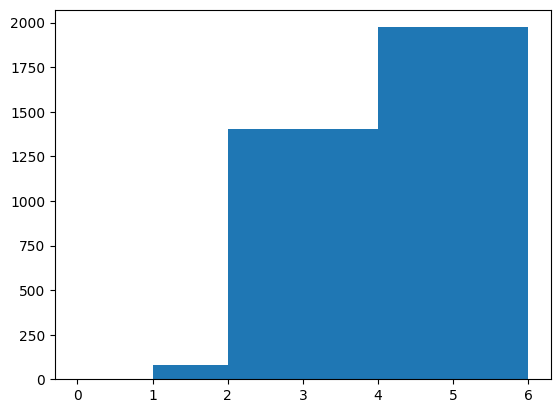

In [733]:
plt.hist(df_train["NumberOfFollowups_nan-1"], bins=[0, 1, 2,4,6])

In [734]:
#ÊúÄÈ†ªÂÄ§„ÇíÂèñÂæó
most_frequent_value = df_train['NumberOfFollowups_max'].mode()[0]

# df_train „Å´ÈÅ©Áî® (NaN ÂÄ§„Å® 0 „ÇíÂêåÊôÇ„Å´ÁΩÆÊèõ)
df_train['NumberOfFollowups_max'] = df_train['NumberOfFollowups_max'].replace({0: most_frequent_value, np.nan: most_frequent_value})

# df_test „Å´„ÇÇÂêåÊßò„ÅÆÂá¶ÁêÜ„ÇíÈÅ©Áî®
df_test['NumberOfFollowups_max'] = df_test['NumberOfFollowups_max'].replace({0: most_frequent_value, np.nan: most_frequent_value})

In [735]:
print(df_train['NumberOfFollowups_max'].isnull().sum())  # NaN ÂÄ§„ÅÆÊï∞„ÇíË°®Á§∫
print(df_train['NumberOfFollowups_max'].value_counts())  # ÂêÑÂÄ§„ÅÆÂá∫ÁèæÂõûÊï∞„ÇíË°®Á§∫


0
NumberOfFollowups_max
4.0    1444
3.0    1296
5.0     524
2.0     108
1.0      78
6.0      39
Name: count, dtype: int64


In [736]:
#ÂêÑÊÑèÂë≥Âêà„ÅÑ„Å´Ê≤ø„Å£„Å¶rankÂåñ
rank_dict = {
    'king': 5,
    'superdeluxe': 4,
    'deluxe': 3,
    'standard': 2,
    'basic': 1
}


df_train['ProductPitched_Score'] = df_train['ProductPitched_low'].map(rank_dict)

# df_test „Å´„ÇÇ ProductPitched_Score „Ç´„É©„É†„ÇíËøΩÂä†
df_test['ProductPitched_Score'] = df_test['ProductPitched_low'].map(rank_dict)

In [737]:
df_train["ProductPitched_Score"] = df_train["ProductPitched_Score"].astype(int)
df_test["ProductPitched_Score"] = df_test["ProductPitched_Score"].astype(int)

In [738]:
#Ê¨†ÊêçÂÄ§„Å®„Åó„Å¶Êâ±„ÅÜÁâπÂæ¥Èáè„Å®„Åó„Å¶„Åä„Åè
df_train["NumberOfTrips_year-1"] = df_train["NumberOfTrips_year"].replace(0, -1)

df_test["NumberOfTrips_year-1"] = df_test["NumberOfTrips_year"].replace(0, -1)

df_train["NumberOfTrips_year-1"].value_counts()

NumberOfTrips_year-1
 2    1164
 3     820
 5     515
 1     409
 7     256
 4     163
 6     130
-1      22
 8      10
Name: count, dtype: int64

In [739]:
#„Çπ„Ç≥„Ç¢Âåñ„Åó„ÅüËâØ„ÅÑÂïÜÂìÅ*Ê∫ÄË∂≥Â∫¶„ÅÆ„Çπ„Ç≥„Ç¢
#‚ÜíÂ£≤„ÇäËæº„ÅøÂïÜÂìÅ„ÅåËâØ„Åè„Å¶Ê∫ÄË∂≥Â∫¶„ÅåÈ´ò„Åë„Çå„Å∞ÊàêÁ¥ÑÁéá„ÇÇÈ´ò„ÅÑ„ÅØ„Åö
df_train["Product_Score"] = df_train["ProductPitched_Score"]*df_train["PitchSatisfactionScore"]

df_test["Product_Score"] = df_test["ProductPitched_Score"]*df_test["PitchSatisfactionScore"]

df_train["Product_Score"].value_counts()

Product_Score
4     684
2     652
6     559
3     449
12    311
8     241
9     185
1     157
10     52
15     48
5      47
16     46
20     34
25     24
Name: count, dtype: int64

In [740]:
df_test["Product_Score"].value_counts()

Product_Score
2     653
4     623
6     547
3     446
12    309
8     219
1     204
9     174
10     79
5      66
20     49
15     48
16     43
25     29
Name: count, dtype: int64

In [741]:
#„Çπ„Ç≥„Ç¢Âåñ„Åó„ÅüËâØ„ÅÑÂïÜÂìÅ*È°ßÂÆ¢„Å´„Çà„Çã„Éõ„ÉÜ„É´ÊñΩË®≠„ÅÆÂÑ™ÂÖàË©ï‰æ°
#‚ÜíËâØ„ÅÑÂïÜÂìÅ„Åß„ÅÇ„Çä„ÄÅÊñΩË®≠„ÅÆË©ï‰æ°„ÇÇÈ´ò„Åë„Çå„Å∞ÊàêÁ¥ÑÁéá„ÅåÈ´ò„Åè„Å™„Çä„Åù„ÅÜ
df_train["Product_Property_Score"] = df_train["ProductPitched_Score"] * df_train["PreferredPropertyStar"]

# df_test „Å´ Product_Property_Score „Ç´„É©„É†„ÇíËøΩÂä†
df_test["Product_Property_Score"] = df_test["ProductPitched_Score"] * df_test["PreferredPropertyStar"]

In [742]:
# È†ªÂ∫¶„ÇíË®àÁÆó
product_counts = df_train["Designation_low"].value_counts()  # df_train „Å´Â§âÊõ¥

# È†ªÂ∫¶„Å´Âü∫„Å•„ÅÑ„Å¶ÂÄ§„Çí„ÇΩ„Éº„Éà
sorted_products = product_counts.index.tolist()

# „É©„Éô„É´„Ç®„É≥„Ç≥„Éº„ÉÄ„Éº„Çí‰ΩúÊàê
le = LabelEncoder()

# È†ªÂ∫¶„Å´Âü∫„Å•„ÅÑ„Å¶„É©„Éô„É´„Çí„Ç®„É≥„Ç≥„Éº„Éâ (df_train „Åß fit)
le.fit(df_train["Designation_low"])  # df_train["Designation_low"] „Åß fit

# df_train „Å´ Designation_le „Ç´„É©„É†„ÇíËøΩÂä†
df_train["Designation_le"] = le.transform(df_train["Designation_low"])

# df_test „Å´ Designation_le „Ç´„É©„É†„ÇíËøΩÂä† (df_train „Åß fit „Åó„Åü le „Çí‰ΩøÁî®)
df_test["Designation_le"] = le.transform(df_test["Designation_low"])

In [743]:
df_train["Designation_le"].value_counts()

Designation_le
0    1150
1    1055
2     854
3     430
Name: count, dtype: int64

In [744]:
#rankÂåñ„Åó„Å¶‰ΩøÁî®„Åô„ÇãÁâπÂæ¥Èáè„Å®„Åó„Å¶‰ΩúÊàê
rank_dict = {
    'vip': 4,
    'executive': 3,
    'seniormanager': 2,
    'manager': 1
}

# df_train „Å´ Designation_rank „Ç´„É©„É†„ÇíËøΩÂä†
df_train["Designation_rank"] = df_train["Designation_low"].map(rank_dict)

# df_test „Å´ Designation_rank „Ç´„É©„É†„ÇíËøΩÂä†
df_test["Designation_rank"] = df_test["Designation_low"].map(rank_dict)

In [745]:
df_train["Designation_rank"].value_counts()

Designation_rank
3    1150
1    1055
2     854
4     430
Name: count, dtype: int64

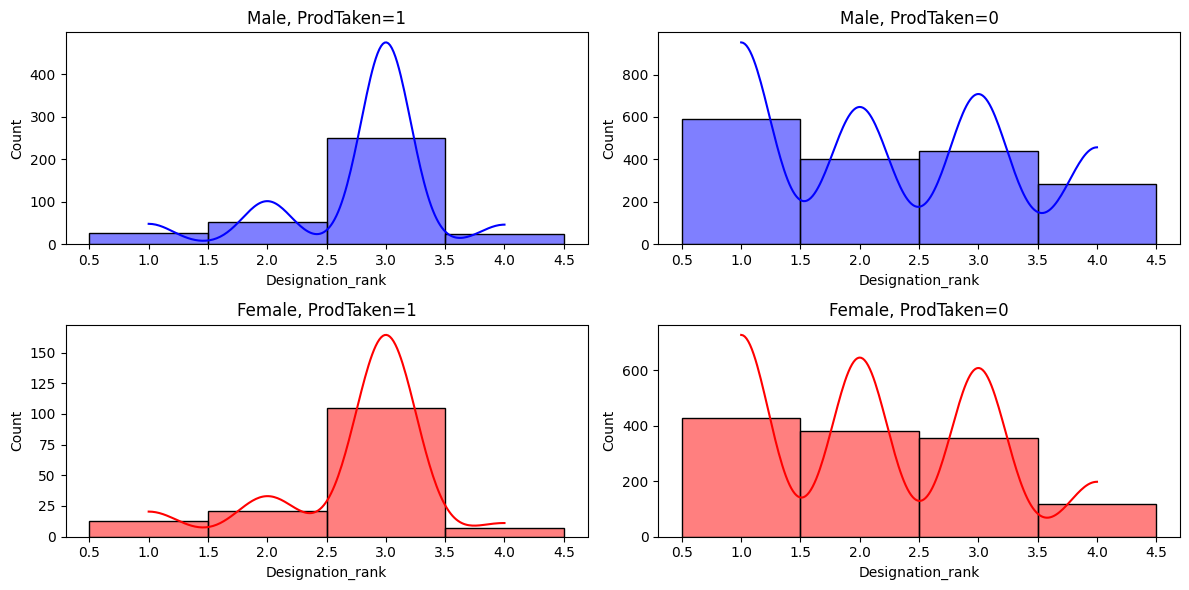

In [746]:
# Gender_enc„Å®ProdTaken„Åß„Éá„Éº„Çø„ÇíÂàÜÂâ≤
#ÁâπÂæ¥Èáè„ÇíÂ§â„Åà„Å¶Ë¶ñË¶öÂåñ
male_prodtaken_data = df_train[(df_train['Gender_enc'] == 1) & (df_train['ProdTaken'] == 1)]['Designation_rank']
male_notprodtaken_data = df_train[(df_train['Gender_enc'] == 1) & (df_train['ProdTaken'] == 0)]['Designation_rank']
female_prodtaken_data = df_train[(df_train['Gender_enc'] == 0) & (df_train['ProdTaken'] == 1)]['Designation_rank']
female_notprodtaken_data = df_train[(df_train['Gender_enc'] == 0) & (df_train['ProdTaken'] == 0)]['Designation_rank']

# ÂÖ®„Éá„Éº„Çø„ÅÆDesignation_rank„ÅÆÊúÄÂ∞èÂÄ§„Å®ÊúÄÂ§ßÂÄ§„ÇíÂèñÂæó
min_rank = df_train['Designation_rank'].astype(int).min()
max_rank = df_train['Designation_rank'].astype(int).max()

# bin„ÅÆ„Ç®„ÉÉ„Ç∏„ÇíÊåáÂÆö (‰æã: ÊúÄÂ∞èÂÄ§„Åã„ÇâÊúÄÂ§ßÂÄ§„Åæ„Åß„Çí1Âàª„Åø)
bins = np.arange(min_rank, max_rank + 2, 1)  # +2„ÅØÊúÄÂ§ßÂÄ§„ÇíÂê´„ÇÅ„Çã„Åü„ÇÅ

# „Éí„Çπ„Éà„Ç∞„É©„É†„Çí‰ΩúÊàê
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.histplot(male_prodtaken_data, color='blue', kde=True, bins=bins)  # binsÂºïÊï∞„ÇíÊåáÂÆö
plt.title('Male, ProdTaken=1')

plt.subplot(2, 2, 2)
sns.histplot(male_notprodtaken_data, color='blue', kde=True, bins=bins)  # binsÂºïÊï∞„ÇíÊåáÂÆö
plt.title('Male, ProdTaken=0')

plt.subplot(2, 2, 3)
sns.histplot(female_prodtaken_data, color='red', kde=True, bins=bins)  # binsÂºïÊï∞„ÇíÊåáÂÆö
plt.title('Female, ProdTaken=1')

plt.subplot(2, 2, 4)
sns.histplot(female_notprodtaken_data, color='red', kde=True, bins=bins)  # binsÂºïÊï∞„ÇíÊåáÂÆö
plt.title('Female, ProdTaken=0')
plt.tight_layout()
plt.show()

In [747]:
# Ê¨†ÊêçÂÄ§„Å®„Åó„Å¶Êâ±„ÅÜ
df_train["MonthlyIncome_ext-1"] = pd.to_numeric(df_train["MonthlyIncome_ext"], errors='coerce').fillna(-1).astype(int)

# df_test „Å´ MonthlyIncome_ext-1 „Ç´„É©„É†„ÇíËøΩÂä†
df_test["MonthlyIncome_ext-1"] = pd.to_numeric(df_test["MonthlyIncome_ext"], errors='coerce').fillna(-1).astype(int)

In [748]:
#0 „ÇíÂê´„ÇÄÊ¨†ÊêçÂÄ§„Çí‰∏≠Â§ÆÂÄ§„ÅßË£úÂÆå„Åó„ÅüÁâπÂæ¥Èáè„ÇÇ‰ΩúÊàê
median_income_train = df_train["MonthlyIncome_ext"].median()


df_train["MonthlyIncome_0_med"] = df_train["MonthlyIncome_ext"].copy()
df_train.loc[df_train["MonthlyIncome_0_med"] == 0, "MonthlyIncome_0_med"] = np.nan
df_train["MonthlyIncome_0_med"] = df_train["MonthlyIncome_0_med"].fillna(median_income_train)

# df_test „Å´„ÇÇÂêåÊßò„ÅÆÂá¶ÁêÜ„ÇíÈÅ©Áî®
df_test["MonthlyIncome_0_med"] = df_test["MonthlyIncome_ext"].copy()
df_test.loc[df_test["MonthlyIncome_0_med"] == 0, "MonthlyIncome_0_med"] = np.nan
df_test["MonthlyIncome_0_med"] = df_test["MonthlyIncome_0_med"].fillna(median_income_train)

# Á¢∫Ë™ç
print(df_train["MonthlyIncome_0_med"].isnull().sum())

0


In [749]:
# MonthlyIncome_0_med „ÇíÊõ¥Êñ∞ (Áôæ„ÅÆ‰Ωç„ÇíÂõõÊç®‰∫îÂÖ•)
df_train["MonthlyIncome_0_med"] = (df_train["MonthlyIncome_0_med"] / 1000).round() * 1000

df_test["MonthlyIncome_0_med"] = (df_test["MonthlyIncome_0_med"] / 1000).round() * 1000

In [750]:
df_train["MonthlyIncome_0_med"].isnull().sum()

0

In [751]:
# Èõ¢Â©ö„ÅØ„Åó„Å¶„ÅÑ„Çã„Åå‰∏Ä‰∫∫ÊöÆ„Çâ„Åó„Åß„Å™„ÅÑÂèØËÉΩÊÄß„ÇÇ„ÅÇ„Çã„Åü„ÇÅ„ÄÅÊï∞ÂÄ§Ââ≤„ÇäÊåØ„Çä„ÇíÂ§â„Åà„Åü„ÇÇ„ÅÆ
def convert_material_info2(value):
  if value in ["ÁµêÂ©öÊ∏à„Åø"]:
    return 3
  elif value in ["Èõ¢Â©öÊ∏à„Åø"]:
    return 2
  elif value in ["Áã¨Ë∫´", "Êú™Â©ö"]:
    return 1
  else:
    return value

# df_train„Å´ÈÅ©Áî®
df_train['material_count2'] = df_train['material_status'].copy()
df_train["material_score"] = df_train["material_count2"].apply(convert_material_info2)

# df_test„Å´ÈÅ©Áî®
df_test['material_count2'] = df_test['material_status'].copy()
df_test["material_score"] = df_test["material_count2"].apply(convert_material_info2)

In [752]:
#Âæå„ÄÖ„Ç´„ÉÜ„Ç¥„É™Êâ±„ÅÑ„Å®„Åô„Çã
df_train["material_score"].value_counts()

material_score
3    1384
1    1227
2     878
Name: count, dtype: int64

In [753]:
#df_all["material_count"]„ÅÆÁµêÂ©öÊ∏à„Åø„ÅØÔºí„ÄÅ„Åù„Çå‰ª•Â§ñ„ÅØÔºë„Å®„Åô„Çã„ÄÇ„Ç≥„Éî„Éº„Å™„Çä‰∏ÄÊôÇÁöÑ„Å´ÈÅï„ÅÜÂ§âÊï∞„Å´‰ª£ÂÖ•„Åô„Çã„Å™„Çä„ÄÇ
#Ë∂≥ÁÆó„Åó„Å¶df_all["family"] „Å∏‰ª£ÂÖ•„ÅóÂÆ∂ÊóèÊßãÊàê„ÇíË°®„ÅôÁâπÂæ¥Èáè„Å®„Åô„Çã„ÄÇ

# df_train„Å∏„ÅÆÈÅ©Áî®
df_train["material_temp"] =  np.where(df_train["material_count"] == 0, 1, df_train["material_count"])
df_train["child_temp"] = df_train["child_info_int"]
df_train["family"] = df_train["material_temp"] + df_train["child_temp"]
df_train["family"] = df_train["family"].astype(int)
df_train = df_train.drop(["material_temp", "child_temp"], axis=1)

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test["material_temp"] = np.where(df_test["material_count"] == 0, 1, df_test["material_count"])
df_test["child_temp"] = df_test["child_info_int"]
df_test["family"] = df_test["material_temp"] + df_test["child_temp"]
df_test["family"] = df_test["family"].astype(int)
df_test = df_test.drop(["material_temp", "child_temp"], axis=1)

# Êó¢Â©ö + Â≠ê‰æõÊúâÁÑ°
# Êú™Â©ö„ÉªÈõ¢Â©ö + Â≠ê‰æõÊúâÁÑ°

In [754]:
df_train["family"].value_counts()

family
2    1235
3    1139
1     690
4     392
5      33
Name: count, dtype: int64

In [755]:
# NumberOfPersonVisiting „Å® family „ÅÆÁµÑ„ÅøÂêà„Çè„Åõ„Åî„Å®„ÅÆ‰∫∫Êï∞„Çí„Ç´„Ç¶„É≥„Éà
#ÊóÖË°åÂêåË°åËÄÖ„Å®ÂÆ∂ÊóèÊßãÊàê„ÅÆÂâ≤Âêà

# ÈõÜÁ¥Ñ„ÉÜ„Éº„Éñ„É´„ÅÆ‰ΩúÊàê (df_train„Åæ„Åü„ÅØdf_test„Çí‰ΩøÁî®)
df_fam = pd.crosstab(df_train["NumberOfPersonVisiting"], df_train["family"], normalize="index")  # df_train„Çí‰ΩøÁî®
df_fam = df_fam.reset_index()
df_fam = pd.melt(df_fam, id_vars="NumberOfPersonVisiting", value_name="family_travel_share")

# df_train„Å∏„ÅÆÈÅ©Áî®
df_train = pd.merge(df_train, df_fam, on=["NumberOfPersonVisiting", "family"], how="left")

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test = pd.merge(df_test, df_fam, on=["NumberOfPersonVisiting", "family"], how="left")

# ÂÖ®‰Ωì„ÅÆË¶ÅÁ¥†Êï∞„ÅßÂâ≤„Å£„Å¶ÊØîÁéá„ÇíË®àÁÆó.%„ÅåÂ§ö„ÅÑ„Åª„Å©Â≠ê‰æõ„ÇíÈÄ£„Çå„Å¶„ÅÑ„ÅèÂèØËÉΩÊÄß„ÅåÈ´ò„ÅÑ
#ÊÑèÂ§ñ„Å®‰∏Ä‰∫∫ÊóÖ„ÅÆÂâ≤ÂêàÈ´ò„ÅÑÂèØËÉΩÊÄß

In [756]:
df_test["family_travel_share"].value_counts()

family_travel_share
0.501866    780
0.481481    660
0.268035    466
0.246187    380
0.230100    309
0.209877    279
0.693452    231
0.306548    119
0.062455     77
0.267857     62
0.315476     50
0.214286     41
0.196429     34
0.005952      1
Name: count, dtype: int64

In [757]:
df_train["family"].value_counts()

family
2    1235
3    1139
1     690
4     392
5      33
Name: count, dtype: int64

In [758]:
df_train["NumberOfPersonVisiting"].value_counts()

NumberOfPersonVisiting
2.0    1608
3.0    1377
1.0     336
4.0     168
Name: count, dtype: int64

In [759]:
#ÊóÖË°åË®àÁîª„Å´Êï∞„Åà„Çâ„Çå„Å¶„ÅÑ„Çã‰∫∫Êï∞/‰∏ñÂ∏Ø‰∫∫Êï∞
df_train["Travel_fam_New"] = df_train["NumberOfPersonVisiting"] / df_train["family"]

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test["Travel_fam_New"] = df_test["NumberOfPersonVisiting"] / df_test["family"]

In [760]:
df_train["Travel_fam_New"].value_counts()

Travel_fam_New
1.0         1756
0.666667     431
2.0          406
0.75         339
1.5          289
0.5          103
3.0           86
1.333333      45
0.8           33
4.0            1
Name: count, dtype: int64

In [761]:
df_train["Travel_fam_New"] = df_train["Travel_fam_New"].astype(int)
df_test["Travel_fam_New"] = df_test["Travel_fam_New"].astype(int)

In [762]:
# ÊúàÂèéÂ∏Ø„ÇíÂÆöÁæ© (5‰∏áÂÜÜÂàª„Åø) - df_train„ÅÆÊúÄÂ§ßÂÄ§„Çí‰ΩøÁî®
income_bins = np.arange(0, df_train['MonthlyIncome_0_med'].max() + 50000, 50000)

# df_train„Å∏„ÅÆÈÅ©Áî®
df_train['MonthlyIncome_binned'] = pd.cut(
    df_train['MonthlyIncome_0_med'],
    bins=income_bins,
    labels=False,
    include_lowest=True,
    duplicates='drop'
).astype(int)

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test['MonthlyIncome_binned'] = pd.cut(
    df_test['MonthlyIncome_0_med'],
    bins=income_bins,  # df_train„ÅßË®àÁÆó„Åó„Åüincome_bins„Çí‰ΩøÁî®
    labels=False,
    include_lowest=True,
    duplicates='drop'
).astype(int)


print(df_train[['MonthlyIncome_0_med', 'MonthlyIncome_binned']].head())
print(df_test[['MonthlyIncome_0_med', 'MonthlyIncome_binned']].head())

   MonthlyIncome_0_med  MonthlyIncome_binned
0             254000.0                     5
1             404000.0                     8
2             278000.0                     5
3             327000.0                     6
4             258000.0                     5
   MonthlyIncome_0_med  MonthlyIncome_binned
0             497000.0                     9
1             300000.0                     5
2             260000.0                     5
3             260000.0                     5
4             269000.0                     5


In [763]:
df_train['MonthlyIncome_binned'].isnull().sum()

0

In [764]:
# ‰∏≠Â§ÆÂÄ§„ÇíË®àÁÆó„Åó0 „ÇíÂê´„ÇÄÊ¨†ÊêçÂÄ§„Çí‰∏≠Â§ÆÂÄ§„ÅßË£úÂÆå
median_income_train = df_train["Age_numeric"].median()


df_train["Age_numeric_0_med"] = df_train["Age_numeric"].copy()
df_train.loc[df_train["Age_numeric_0_med"] == 0, "Age_numeric_0_med"] = np.nan
df_train["Age_numeric_0_med"] = df_train["Age_numeric_0_med"].fillna(median_income_train)

# df_test „Å´„ÇÇÂêåÊßò„ÅÆÂá¶ÁêÜ„ÇíÈÅ©Áî®
df_test["Age_numeric_0_med"] = df_test["Age_numeric"].copy()
df_test.loc[df_test["Age_numeric_0_med"] == 0, "Age_numeric_0_med"] = np.nan
df_test["Age_numeric_0_med"] = df_test["Age_numeric_0_med"].fillna(median_income_train)

# Á¢∫Ë™ç
print(df_train["Age_numeric_0_med"].isnull().sum())

0


In [765]:
# Âπ¥ÈΩ¢„ÇíÂÆöÁæ© (ÔºïÊ≠≥Âàª„Åø)
age_bins = np.arange(0, df_train['Age_numeric_0_med'].max() + 5, 5)

# df_train„Å∏„ÅÆÈÅ©Áî®
df_train['Age_numeric_binned'] = pd.cut(
    df_train['Age_numeric_0_med'],
    bins=age_bins,
    labels=False,
    include_lowest=True,
    duplicates='drop'
).astype(int)

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test['Age_numeric_binned'] = pd.cut(
    df_test['Age_numeric_0_med'],
    bins=age_bins,
    labels=False,
    include_lowest=True,
    duplicates='drop'
).astype(int)


print(df_train[['Age_numeric_0_med', 'Age_numeric_binned']].head())
print(df_test[['Age_numeric_0_med', 'Age_numeric_binned']].head())

   Age_numeric_0_med  Age_numeric_binned
0               48.0                   9
1               30.0                   5
2               25.0                   4
3               21.0                   4
4               41.0                   8
   Age_numeric_0_med  Age_numeric_binned
0               48.0                   9
1               30.0                   5
2               25.0                   4
3               21.0                   4
4               41.0                   8


<Axes: >

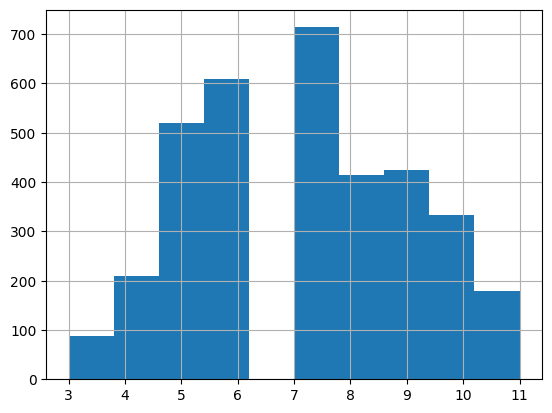

In [766]:
df_train['Age_numeric_binned'].hist()

In [767]:
df_train["Pitch_minutes"].isnull().sum()

121

In [768]:
# MonthlyIncome_0_med „Ç´„É©„É†„ÇíËøΩÂä† (0 „ÇíÂê´„ÇÄÊ¨†ÊêçÂÄ§„Çí‰∏≠Â§ÆÂÄ§„ÅßË£úÂÆå)
df_train["Pitch_minutes_0_med"] = df_train["Pitch_minutes"].copy()  # ÂÖÉ„ÅÆÁâπÂæ¥Èáè„Çí„Ç≥„Éî„Éº
df_train.loc[df_train["Pitch_minutes_0_med"] == 0, "Pitch_minutes_0_med"] = np.nan
df_train["Pitch_minutes_0_med"] = df_train["Pitch_minutes_0_med"].fillna(median_income_train)

# df_test „Å´„ÇÇÂêåÊßò„ÅÆÂá¶ÁêÜ„ÇíÈÅ©Áî®
df_test["Pitch_minutes_0_med"] = df_test["Pitch_minutes"].copy()
df_test.loc[df_test["Pitch_minutes_0_med"] == 0, "Pitch_minutes_0_med"] = np.nan
df_test["Pitch_minutes_0_med"] = df_test["Pitch_minutes_0_med"].fillna(median_income_train)

In [769]:
df_train["Pitch_minutes_0_med"] = df_train["Pitch_minutes_0_med"].astype(int)
df_test["Pitch_minutes_0_med"] = df_test["Pitch_minutes_0_med"].astype(int)

In [770]:
df_train["Pitch_minutes_0_med"].value_counts()

Pitch_minutes_0_med
8     338
9     327
15    284
14    266
16    259
7     239
10    231
13    203
11    160
12    158
17    136
38    121
6      80
18     74
32     53
23     51
22     45
31     43
24     40
25     38
20     36
27     35
33     34
30     31
21     31
34     29
28     29
26     27
35     25
29     20
19     19
5      18
36      7
4       2
Name: count, dtype: int64

In [771]:
#Â£≤„ÇäËæº„Åø„Å´„Åã„Åë„ÅüÊôÇÈñì„Å®„Éï„Ç©„É≠„ÉºÂõûÊï∞„Çí„Åã„Åë„Å¶„ÄÅÂñ∂Ê•≠Â∫¶Âêà„ÅÑ„ÇíÁÆóÂá∫
df_train["time_of_follow_new"] = df_train["NumberOfFollowups_max"] * df_train["Pitch_minutes_0_med"].astype(int)
df_test["time_of_follow_new"] = df_test["NumberOfFollowups_max"] * df_test["Pitch_minutes_0_med"].astype(int)

<Axes: >

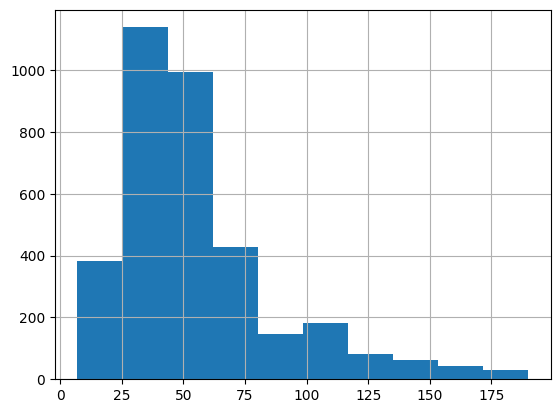

In [772]:
df_train["time_of_follow_new"].hist()

In [773]:
# Âπ¥Âèé„ÅÆÁâπÂæ¥Èáè‰ΩúÊàê
df_train['AnnualIncome'] = df_train['MonthlyIncome_0_med'] * 12
df_train['AnnualIncome_rounded'] = (df_train['AnnualIncome'] / 10000).round().astype(int)

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test['AnnualIncome'] = df_test['MonthlyIncome_0_med'] * 12
df_test['AnnualIncome_rounded'] = (df_test['AnnualIncome'] / 10000).round().astype(int)


print(df_train[['MonthlyIncome_0_med', 'AnnualIncome', 'AnnualIncome_rounded']].head())
print(df_test[['MonthlyIncome_0_med', 'AnnualIncome', 'AnnualIncome_rounded']].head())

   MonthlyIncome_0_med  AnnualIncome  AnnualIncome_rounded
0             254000.0     3048000.0                   305
1             404000.0     4848000.0                   485
2             278000.0     3336000.0                   334
3             327000.0     3924000.0                   392
4             258000.0     3096000.0                   310
   MonthlyIncome_0_med  AnnualIncome  AnnualIncome_rounded
0             497000.0     5964000.0                   596
1             300000.0     3600000.0                   360
2             260000.0     3120000.0                   312
3             260000.0     3120000.0                   312
4             269000.0     3228000.0                   323


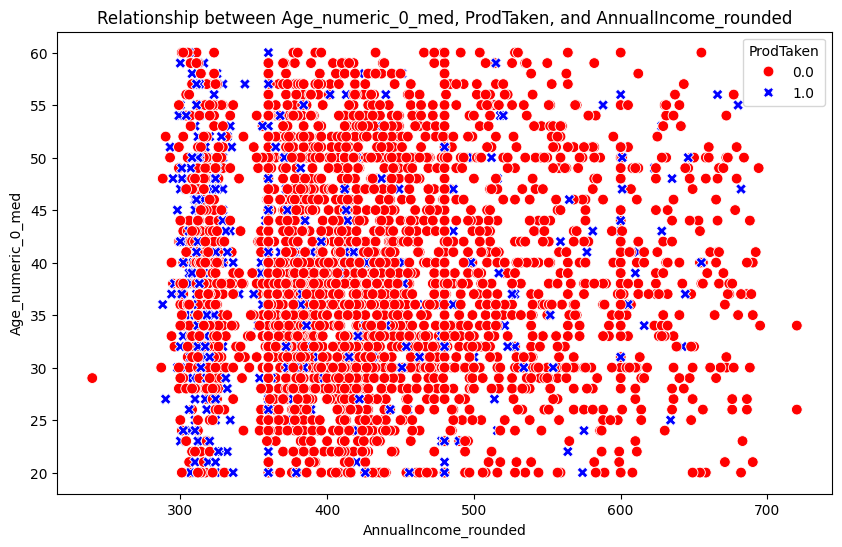

In [774]:
# Êï£Â∏ÉÂõ≥„Çí‰ΩúÊàê:Âπ¥Âèé300‰∏áÂÜÜÂè∞„Å´Ê≠£‰æã„ÅåÂ§ö„ÅÑ
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AnnualIncome_rounded', y='Age_numeric_0_med', hue='ProdTaken', style='ProdTaken', data=df_train, palette=['red', 'blue'], s=60)
plt.title('Relationship between Age_numeric_0_med, ProdTaken, and AnnualIncome_rounded')
plt.xlabel('AnnualIncome_rounded')
plt.ylabel('Age_numeric_0_med')
plt.legend(title='ProdTaken')
plt.show()

In [775]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 63 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       3489 non-null   int64   
 1   Age                      3489 non-null   category
 2   TypeofContact            3483 non-null   category
 3   CityTier                 3489 non-null   int64   
 4   DurationOfPitch          3489 non-null   category
 5   Occupation               3489 non-null   category
 6   Gender                   3489 non-null   category
 7   NumberOfPersonVisiting   3489 non-null   float64 
 8   NumberOfFollowups        3456 non-null   float64 
 9   ProductPitched           3489 non-null   category
 10  PreferredPropertyStar    3489 non-null   float64 
 11  NumberOfTrips            3489 non-null   category
 12  Passport                 3489 non-null   int64   
 13  PitchSatisfactionScore   3489 non-null   int64   
 14  Designat

In [776]:
df_train["family"].isna().sum()

0

In [777]:
# df_train„Å∏„ÅÆÈÅ©Áî®
df_train["MonthlyInc_fam"] = (df_train["MonthlyIncome_0_med"] / df_train["family"]).astype('int64')
df_train["AnnualInc_fam_round"] = (df_train["AnnualIncome_rounded"] / df_train["family"]).astype('int64')

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test["MonthlyInc_fam"] = (df_test["MonthlyIncome_0_med"] / df_test["family"]).astype('int64')
df_test["AnnualInc_fam_round"] = (df_test["AnnualIncome_rounded"] / df_test["family"]).astype('int64')

#
display(df_train[["MonthlyInc_fam", "AnnualInc_fam_round", "family"]].sample(n=10))

MonthlyInc_fam  AnnualInc_fam_round family
2891          113666                  136      3
1150          325000                  390      1
2380          185333                  222      3
2008          130000                  156      2
1874          104000                  124      3
1903          175500                  210      2
2691          142000                  170      3
1737          103666                  124      3
91            256000                  307      1
3196          130666                  156      3

In [778]:
# df_train„Å∏„ÅÆÈÅ©Áî®
df_train["CityTier_reverse"] = df_train["CityTier"].replace({1: 3, 3: 1})

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test["CityTier_reverse"] = df_test["CityTier"].replace({1: 3, 3: 1})

#
print(df_train[["CityTier", "CityTier_reverse"]].head())

   CityTier  CityTier_reverse
0         2                 2
1         1                 3
2         1                 3
3         2                 2
4         3                 1


In [779]:
# df_train„Å∏„ÅÆÈÅ©Áî®
df_train["Age_Trips"] = df_train["Age_numeric_0_med"] * df_train["NumberOfTrips_year"]

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test["Age_Trips"] = df_test["Age_numeric_0_med"] * df_test["NumberOfTrips_year"]


print(df_train["Age_Trips"].value_counts())

Age_Trips
60.0     100
90.0      90
80.0      74
150.0     70
114.0     66
        ... 
258.0      1
368.0      1
424.0      1
392.0      1
456.0      1
Name: count, Length: 209, dtype: int64


In [780]:
#Âπ¥ÈñìÊóÖË°å‰∫∫Êï∞/Âπ¥ÈΩ¢ ÔºùÂπ¥ÈΩ¢„Å´ÂØæ„Åô„ÇãÊóÖË°åÈ†ªÂ∫¶
df_train["travel_frequency"] = np.where(df_train["NumberOfTrips_year"] != 0,
                                         df_train["Age_numeric_0_med"] / df_train["NumberOfTrips_year"],
                                         df_train["Age_numeric_0_med"])

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test["travel_frequency"] = np.where(df_test["NumberOfTrips_year"] != 0,
                                         df_test["Age_numeric_0_med"] / df_test["NumberOfTrips_year"],
                                         df_test["Age_numeric_0_med"])


print(df_train["travel_frequency"].value_counts())

travel_frequency
10.000000    117
15.000000     97
20.000000     83
18.000000     69
19.000000     68
            ... 
2.500000       1
3.500000       1
9.833333       1
7.166667       1
7.125000       1
Name: count, Length: 222, dtype: int64


In [781]:
#Êéõ„ÅëÂêà„Çè„Åõ„ÇãÔºùÂêÑ„ÇØ„É©„Çπ„Åî„Å®„ÅÆ‰∏ñÂ∏ØÂπ¥ÂèéÔºù‰ΩôË£ïÂ∫¶
df_train["Designation_Annual"] = df_train["Designation_rank"].astype(int) * df_train["AnnualInc_fam_round"]

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test["Designation_Annual"] = df_test["Designation_rank"].astype(int) * df_test["AnnualInc_fam_round"]

#
print(df_train[["Designation_rank", "AnnualInc_fam_round", "Designation_Annual"]].head())

  Designation_rank  AnnualInc_fam_round  Designation_Annual
0                3                  305                 915
1                2                  485                 970
2                3                  167                 501
3                2                  392                 784
4                3                  310                 930


In [782]:
#‰∏ñÂ∏ØÊúàÂèé„Åß„ÇÇ‰∏ÄÂøú‰ΩúÊàê
df_train["Designation_Month"] = df_train["Designation_rank"].astype(int) * df_train["MonthlyInc_fam"]

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test["Designation_Month"] = df_test["Designation_rank"].astype(int) * df_test["MonthlyInc_fam"]

#
print(df_train[["Designation_rank", "MonthlyInc_fam", "Designation_Month"]].head())

  Designation_rank  MonthlyInc_fam  Designation_Month
0                3          254000             762000
1                2          404000             808000
2                3          139000             417000
3                2          327000             654000
4                3          258000             774000


In [783]:
# ÊóÖË°åÈñìÈöî„ÇíË®àÁÆó„Åô„ÇãÈñ¢Êï∞
def calc_travel_interval(trips_per_year):
  if pd.isna(trips_per_year):
    return np.nan
  elif trips_per_year == 0:
    return 0  # ÊóÖË°åÂõûÊï∞„Åå0Âõû„ÅÆÂ†¥Âêà„ÅØÊóÖË°åÈñìÈöî„Çí0„Å®„Åô„Çã
  else:
    return 12 / trips_per_year

# df_train„Å∏„ÅÆÈÅ©Áî®
df_train['Travel_Interval'] = df_train['NumberOfTrips_year'].apply(calc_travel_interval).astype(int)

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test['Travel_Interval'] = df_test['NumberOfTrips_year'].apply(calc_travel_interval).astype(int)

print(df_train['Travel_Interval'].value_counts())

Travel_Interval
6     1164
4      820
2      645
12     409
1      266
3      163
0       22
Name: count, dtype: int64


In [784]:
#Âπ¥ÈΩ¢Ôºä‰∏ñÂ∏ØÂèéÂÖ•
df_train["Age_Annual"] = df_train["AnnualIncome_rounded"] * df_train["Age_numeric_0_med"].astype(int)

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test["Age_Annual"] = df_test["AnnualIncome_rounded"] * df_test["Age_numeric_0_med"].astype(int)

print(df_train["Age_Annual"].value_counts())

Age_Annual
10800    26
14400    17
18240    15
11520    14
16200    12
         ..
16974     1
9044      1
12616     1
17682     1
14696     1
Name: count, Length: 2184, dtype: int64


In [785]:
df_test['MonthlyIncome_0_med'].describe()

count      3489.000000
mean     356400.687876
std       76592.354156
min      200000.000000
25%      300000.000000
50%      342000.000000
75%      400000.000000
max      600000.000000
Name: MonthlyIncome_0_med, dtype: float64

In [786]:
# Âπ¥ÈΩ¢Â±§„ÇíÂÆöÁæ©
age_bins = [0, 29, 39, 49, 59, float('inf')]
age_labels = ['20s', '30s', '40s', '50s', '60s_over']
income_bins = np.arange(0, df_train['MonthlyIncome_0_med'].max() + 50000, 50000)


# Âπ¥ÈΩ¢Â±§Âà•„ÉªÊúàÂèéÂ∏ØÂà•ÂÅèÂ∑ÆÂÄ§„ÇíÁÆóÂá∫„Åô„ÇãÈñ¢Êï∞„ÇíÂÆöÁæ©
def calculate_age_income_zscore(row, stats):
    age_income_group = row['age_income_group']
    monthly_income = row['MonthlyIncome_0_med']

    if age_income_group in stats.index:
        mean = stats.loc[age_income_group, 'mean']
        std = stats.loc[age_income_group, 'std']

        if std == 0:
            return 0  # Ê®ôÊ∫ñÂÅèÂ∑Æ„Åå0„ÅÆÂ†¥Âêà„ÅØÂÅèÂ∑ÆÂÄ§„Çí0„Å®„Åô„Çã
        else:
            return (monthly_income - mean) / std  # ÂÅèÂ∑ÆÂÄ§„ÇíË®àÁÆó
    else:
        median_zscore = stats['zscore'].median()  # stats DataFrame „Åã„Çâ zscore „ÅÆ‰∏≠Â§ÆÂÄ§„ÇíÂèñÂæó
        return median_zscore

# 'age_income_group' „Ç´„É©„É†„Çí‰ΩúÊàê
df_train['age_group'] = pd.cut(df_train['Age_numeric_0_med'], bins=age_bins, labels=age_labels, include_lowest=True, duplicates='drop')
df_train['income_group'] = pd.cut(df_train['MonthlyIncome_0_med'], bins=income_bins, labels=False, include_lowest=True, duplicates='drop')
df_train['age_income_group'] = df_train['age_group'].astype(str) + '_' + df_train['income_group'].astype(str)

df_test['age_group'] = pd.cut(df_test['Age_numeric_0_med'], bins=age_bins, labels=age_labels, include_lowest=True, duplicates='drop')
df_test['income_group'] = pd.cut(df_test['MonthlyIncome_0_med'], bins=income_bins, labels=False, include_lowest=True, duplicates='drop')
df_test['age_income_group'] = df_test['age_group'].astype(str) + '_' + df_test['income_group'].astype(str)


# stats DataFrame „ÅÆ‰ΩúÊàê
stats = df_train.groupby('age_income_group')['MonthlyIncome_0_med'].agg(['mean', 'std'])
stats['zscore'] = stats.apply(lambda row: 0 if row['std'] == 0 else (df_train['MonthlyIncome_0_med'].median() - row['mean']) / row['std'], axis=1)  # zscore „Ç´„É©„É†„ÇíÂàùÊúüÂåñ„ÄÅ‰∏≠Â§ÆÂÄ§„ÅßÂüã„ÇÅ„Çã

# stats DataFrame „ÅÆ‰ΩúÊàê
stats = df_train.groupby('age_income_group')['MonthlyIncome_0_med'].agg(['mean', 'std'])
stats['zscore'] = stats.apply(lambda row: 0 if row['std'] == 0 else (df_train['MonthlyIncome_0_med'].median() - row['mean']) / row['std'], axis=1) # zscore „Ç´„É©„É†„ÇíÂàùÊúüÂåñ„ÄÅ‰∏≠Â§ÆÂÄ§„ÅßÂüã„ÇÅ„Çã


# Âπ¥ÈΩ¢Â±§Âà•„ÉªÊúàÂèéÂ∏ØÂà•ÂÅèÂ∑ÆÂÄ§„ÇíÁÆóÂá∫„Åó„ÄÅÊñ∞„Åó„ÅÑ„Ç´„É©„É†„Å´ËøΩÂä†
df_train['income_zscore_by_age'] = df_train.apply(calculate_age_income_zscore, args=(stats,), axis=1)

# df_test „Å´„ÇÇÂÅèÂ∑ÆÂÄ§„ÇíË®àÁÆó„Åó„ÄÅ'income_zscore_by_age' „Ç´„É©„É†ËøΩÂä†
df_test['income_zscore_by_age'] = df_test.apply(calculate_age_income_zscore, args=(stats,), axis=1)

#
print(df_train[['age_income_group', 'MonthlyIncome_0_med', 'income_zscore_by_age']].head())

  age_income_group  MonthlyIncome_0_med  income_zscore_by_age
0            40s_5             254000.0             -1.197206
1            30s_8             404000.0             -1.470061
2            20s_5             278000.0              0.256426
3            20s_6             327000.0             -0.032776
4            40s_5             258000.0             -0.964625


In [787]:
print(df_train[['Age_numeric_0_med', 'MonthlyIncome_0_med', 'income_zscore_by_age']].head())

   Age_numeric_0_med  MonthlyIncome_0_med  income_zscore_by_age
0               48.0             254000.0             -1.197206
1               30.0             404000.0             -1.470061
2               25.0             278000.0              0.256426
3               21.0             327000.0             -0.032776
4               41.0             258000.0             -0.964625


In [788]:
#income_zscore_by_age„ÅÆÂπ≥ÂùáÂÄ§„ÇíË®àÁÆó„Åó„Å¶0Ë£úÂÆå
mean_zscore = df_train["income_zscore_by_age"].mean()


df_train["income_zscore_by_age"] = df_train["income_zscore_by_age"].replace(0, mean_zscore)

# df_test „Å´ÈÅ©Áî®
df_test["income_zscore_by_age"] = df_test["income_zscore_by_age"].replace(0, mean_zscore)


print(df_train["income_zscore_by_age"].value_counts())

income_zscore_by_age
 1.460466    76
 1.477483    54
 1.543817    50
 1.362403    39
 1.421970    36
             ..
-0.514836     1
-0.090016     1
-0.197167     1
-1.783337     1
 0.153039     1
Name: count, Length: 994, dtype: int64


In [789]:
#È°ßÂÆ¢„ÅÆ„É©„É≥„ÇØ„Å®ÂïÜÂìÅ„É©„É≥„ÇØ„Å´Âü∫„Å•„ÅèÂñ∂Ê•≠Ê∫ÄË∂≥Â∫¶
df_train["Rank_Pitch"] = df_train['ProductPitched_Score'] * df_train['Designation_rank'].astype(int)

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test["Rank_Pitch"] = df_test['ProductPitched_Score'] * df_test['Designation_rank'].astype(int)


print(df_train["Rank_Pitch"].value_counts())

Rank_Pitch
3     2152
4      826
16     298
20     113
2       24
6       19
8       18
1       11
12      10
10       8
9        5
15       4
5        1
Name: count, dtype: int64


In [790]:
# Âπ¥ÈΩ¢Âà•„Çπ„ÉÜ„Éº„Çø„Çπ
df_train["Status_of_age"] = (df_train["child_info_int"] + df_train["material_score"] + df_train["car_status_count"]) / df_train["Age_numeric_0_med"]
df_train["Status_of_age"] = df_train["Status_of_age"].astype(float)

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test["Status_of_age"] = (df_test["child_info_int"] + df_test["material_score"] + df_test["car_status_count"]) / df_test["Age_numeric_0_med"]
df_test["Status_of_age"] = df_test["Status_of_age"].astype(float)


#
print(df_train["Status_of_age"].value_counts())

Status_of_age
0.100000    118
0.125000     84
0.090909     77
0.133333     72
0.066667     71
           ... 
0.300000      1
0.175000      1
0.020408      1
0.304348      1
0.240000      1
Name: count, Length: 193, dtype: int64


In [791]:
#ÁµêÂ©öÊúâÁÑ°+ËªäÊúâÁÑ°+Â≠ê‰æõ‰∫∫Êï∞+‰∏ÄÁ∑í„Å´ÊóÖË°å„ÇíË®àÁîª„Åó„Å¶„ÅÑ„Çã‰∫∫ÔºäÂπ¥ÈñìÊóÖË°åÂõûÊï∞
#‚Üí„É¶„Éº„Ç∂„Éº„ÅÆ„Çπ„ÉÜ„Éº„Çø„Çπ„Å®ÊóÖË°åÈ†ªÂ∫¶„ÅÆÈñ¢‰øÇ„ÅÆÂº∑Ë™ø
df_train["Status_of_travel"] = (df_train["child_info_int"] + df_train["material_score"] + df_train["car_status_count"]) * df_train["NumberOfTrips_year"]
df_train["Status_of_travel"] = df_train["Status_of_travel"].astype(int)

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test["Status_of_travel"] = (df_test["child_info_int"] + df_test["material_score"] + df_test["car_status_count"]) * df_test["NumberOfTrips_year"]
df_test["Status_of_travel"] = df_test["Status_of_travel"].astype(int)

#
print(df_train["Status_of_travel"].value_counts())

Status_of_travel
6     481
12    351
4     348
8     336
15    266
10    264
20    188
9     184
2     169
3     129
25    107
5      90
18     79
30     72
21     72
28     67
14     50
24     45
16     44
35     41
1      36
0      22
42     19
7      11
36      8
49      5
32      3
48      1
40      1
Name: count, dtype: int64


<Axes: >

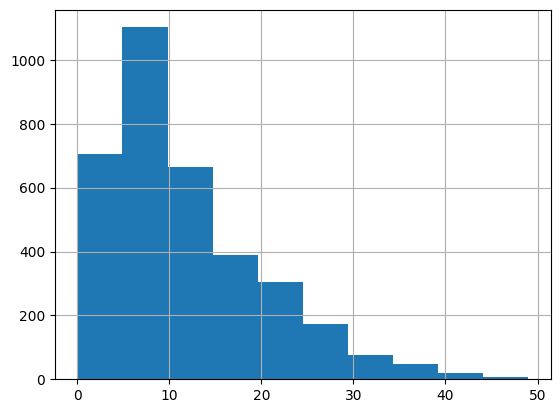

In [792]:
df_train["Status_of_travel"].hist()

In [793]:
# ÊÑèÂë≥Âêà„ÅÑ„Å´Ê≤ø„Å£„Å¶rankÂåñ
rank_dict = {
    'Large Business': 3,
    'Small Business': 2,
    'Salaried': 1,
}

# df_train„Å∏„ÅÆÈÅ©Áî®
df_train['Occupation_rank'] = df_train['Occupation'].map(rank_dict).astype(int)

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test['Occupation_rank'] = df_test['Occupation'].map(rank_dict).astype(int)

print(df_train["Occupation_rank"].value_counts())

Occupation_rank
2    1727
1    1401
3     361
Name: count, dtype: int64


In [794]:
#ËÅ∑Ê•≠„É©„É≥„ÇØ√óÈÉΩÂ∏Ç„É©„É≥„ÇØ=ÂèéÂÖ•„ÅåÈ´ò„ÅÑ‰∫∫„ÅØÈÉΩÂ∏ÇËøëÈÉäÔºà‰∏Ä„Å§„ÅÆÁµåÊ∏àÊåáÊ®ôÔºâ
df_train["JobCityRank"] = df_train["Occupation_rank"] * df_train["CityTier_reverse"]

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test["JobCityRank"] = df_test["Occupation_rank"] * df_test["CityTier_reverse"]


print(df_train["JobCityRank"].value_counts())

JobCityRank
2    859
4    842
6    780
3    636
9    210
1    162
Name: count, dtype: int64


In [795]:
#Occupation_rank„ÅÆÂêÑÂÄ§„Å´ÂØæ„Åô„ÇãCityTier_reverse„ÅÆÂá∫ÁèæÂõûÊï∞„ÇíË®àÁÆó
citytier_reverse_counts = df_train.groupby("Occupation_rank")["CityTier_reverse"].value_counts().to_dict()

# Êñ∞„Åó„ÅÑÁâπÂæ¥Èáè„Çí‰ΩúÊàê
df_train["City_freq_Occupation"] = df_train.apply(
    lambda row: citytier_reverse_counts.get((row["Occupation_rank"], row["CityTier_reverse"]), 0),
    axis=1,
)
df_test["City_freq_Occupation"] = df_test.apply(
    lambda row: citytier_reverse_counts.get((row["Occupation_rank"], row["CityTier_reverse"]), 0),
    axis=1,
)

print(df_train[["Occupation_rank", "CityTier_reverse", "City_freq_Occupation"]].head())


   Occupation_rank  CityTier_reverse  City_freq_Occupation
0                3                 2                   121
1                1                 3                   606
2                3                 3                   210
3                2                 2                   842
4                2                 1                   226


In [796]:
#ÊóÖË°å„Çí‰∫àÂÆö„Åó„Å¶„ÅÑ„Çã‰∫∫Êï∞„ÅåÂ§ö„ÅÑ„Åª„Å©Â£≤„ÇäËæº„ÅøÊ∫ÄË∂≥Â∫¶„ÅÆ„Çπ„Ç≥„Ç¢„ÅåÈ´ò„ÅÑ„ÅÆ„Åß„ÅØ
df_train["GroupTravel_Satisfaction"] = df_train["PitchSatisfactionScore"] * df_train["NumberOfPersonVisiting"]
df_train["GroupTravel_Satisfaction"] = df_train["GroupTravel_Satisfaction"].astype(int)

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test["GroupTravel_Satisfaction"] = df_test["PitchSatisfactionScore"] * df_test["NumberOfPersonVisiting"]
df_test["GroupTravel_Satisfaction"] = df_test["GroupTravel_Satisfaction"].astype(int)

print(df_train["GroupTravel_Satisfaction"].value_counts())

GroupTravel_Satisfaction
6     849
4     680
2     435
8     417
3     349
12    289
9     270
1      56
10     44
15     42
16     41
5      12
20      5
Name: count, dtype: int64


<Axes: >

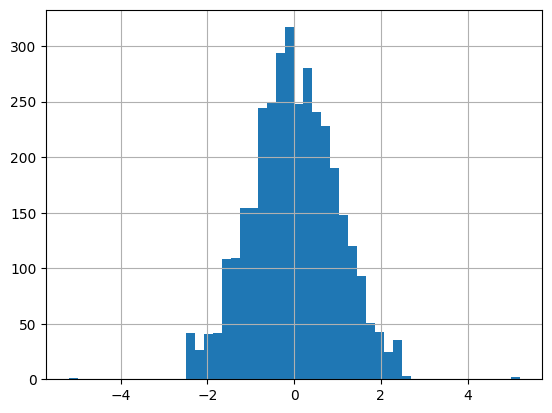

In [797]:
from sklearn.preprocessing import QuantileTransformer

# RANKGAUSS„Ç™„Éñ„Ç∏„Çß„ÇØ„Éà„ÅÆ‰ΩúÊàê
qt = QuantileTransformer(n_quantiles=100, random_state=123, output_distribution='normal')

# df_train„Å∏„ÅÆÈÅ©Áî®
income_data_train = df_train[["MonthlyIncome_0_med"]]
qt.fit(income_data_train)  # df_train„ÅÆ„Éá„Éº„Çø„Åßfit
df_train["M_income_transformed"] = qt.transform(income_data_train)

# df_test„Å∏„ÅÆÈÅ©Áî®
income_data_test = df_test[["MonthlyIncome_0_med"]]
df_test["M_income_transformed"] = qt.transform(income_data_test)  # df_test„ÅÆ„Éá„Éº„Çø„ÇíÂ§âÊèõ

df_train["M_income_transformed"].hist(bins=50)

<Axes: >

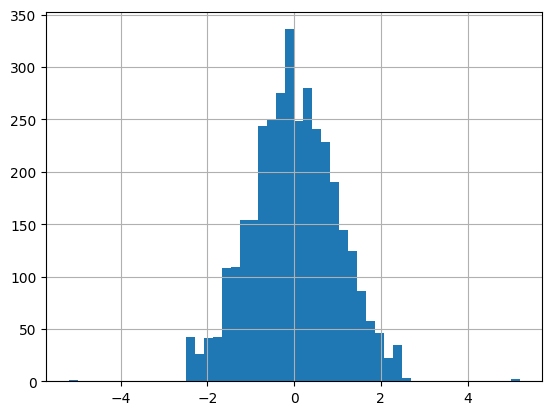

In [798]:
# RANKGAUSS„Ç™„Éñ„Ç∏„Çß„ÇØ„Éà„ÅÆ‰ΩúÊàê
qt = QuantileTransformer(n_quantiles=100, random_state=123, output_distribution='normal')

# Âπ¥Âèé„Åß„ÇÇ‰ΩúÊàê„Åó„Å¶„Åä„Åè
income_data_train = df_train[["AnnualIncome_rounded"]]
qt.fit(income_data_train)  # df_train„ÅÆ„Éá„Éº„Çø„Åßfit
df_train["A_income_transformed"] = qt.transform(income_data_train)

# df_test„Å∏„ÅÆÈÅ©Áî®
income_data_test = df_test[["AnnualIncome_rounded"]]
df_test["A_income_transformed"] = qt.transform(income_data_test)  # df_test„ÅÆ„Éá„Éº„Çø„ÇíÂ§âÊèõ

#
df_train["A_income_transformed"].hist(bins=50)

<Axes: >

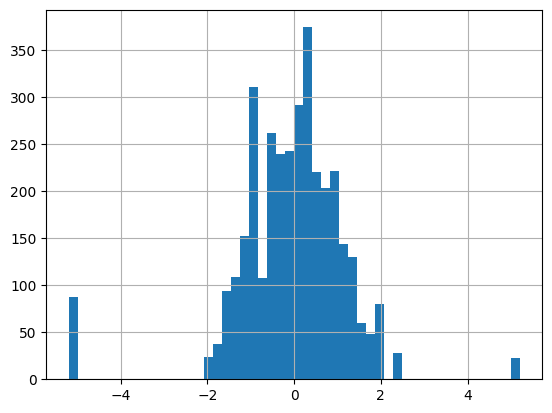

In [799]:
# RANKGAUSS„Ç™„Éñ„Ç∏„Çß„ÇØ„Éà„ÅÆ‰ΩúÊàê
qt = QuantileTransformer(n_quantiles=100, random_state=123, output_distribution='normal')

# df_train„Å∏„ÅÆÈÅ©Áî®
income_data_train = df_train[["Age_numeric_0_med"]]
qt.fit(income_data_train)  # df_train„ÅÆ„Éá„Éº„Çø„Åßfit
df_train["Age_nume_transformed"] = qt.transform(income_data_train)

# df_test„Å∏„ÅÆÈÅ©Áî®
income_data_test = df_test[["Age_numeric_0_med"]]
df_test["Age_nume_transformed"] = qt.transform(income_data_test)  # df_test„ÅÆ„Éá„Éº„Çø„ÇíÂ§âÊèõ

#
df_train["Age_nume_transformed"].hist(bins=50)

<Axes: >

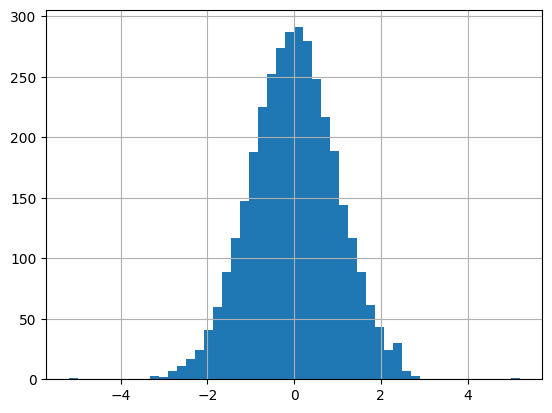

In [800]:
# RANKGAUSS„Ç™„Éñ„Ç∏„Çß„ÇØ„Éà„ÅÆ‰ΩúÊàê
qt = QuantileTransformer(n_quantiles=100, random_state=123, output_distribution='normal')

# df_train„Å∏„ÅÆÈÅ©Áî®
income_data_train = df_train[["Age_Annual"]]
qt.fit(income_data_train)
df_train["Age_ann_transformed"] = qt.transform(income_data_train)

# df_test„Å∏„ÅÆÈÅ©Áî®
income_data_test = df_test[["Age_Annual"]]
df_test["Age_ann_transformed"] = qt.transform(income_data_test)

#
df_train["Age_ann_transformed"].hist(bins=50)

<Axes: >

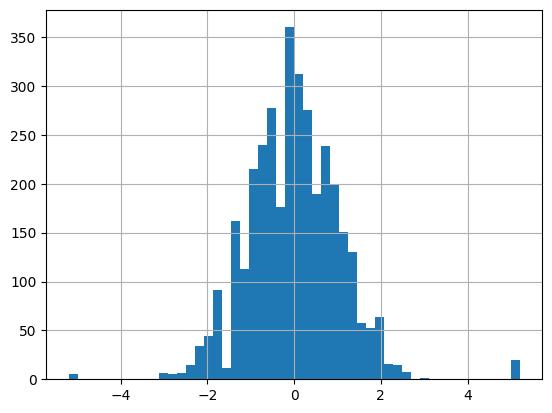

In [801]:
# RANKGAUSS„Ç™„Éñ„Ç∏„Çß„ÇØ„Éà„ÅÆ‰ΩúÊàê
qt = QuantileTransformer(n_quantiles=100, random_state=123, output_distribution='normal')

# df_train„Å∏„ÅÆÈÅ©Áî®
income_data_train = df_train[["time_of_follow_new"]]
qt.fit(income_data_train)
df_train["time_of_transformed"] = qt.transform(income_data_train)

# df_test„Å∏„ÅÆÈÅ©Áî®
income_data_test = df_test[["time_of_follow_new"]]
df_test["time_of_transformed"] = qt.transform(income_data_test)

#
df_train["time_of_transformed"].hist(bins=50)

In [802]:
df_train["time_of_transformed"].describe()

count    3489.000000
mean        0.009761
std         1.064442
min        -5.199338
25%        -0.666564
50%        -0.050661
75%         0.650837
max         5.199338
Name: time_of_transformed, dtype: float64

In [803]:
# „Éõ„ÉÜ„É´„ÅÆË©ï‰æ°*ÂÆ∂ÊóèÊßãÊàê‰∫∫Êï∞
df_train["family"] = df_train["family"].astype(int)
df_train["family_hotel_score"] = df_train["PreferredPropertyStar"] * df_train["family"]
df_train["family_hotel_score"] = df_train["family_hotel_score"].astype(int)

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test["family"] = df_test["family"].astype(int)
df_test["family_hotel_score"] = df_test["PreferredPropertyStar"] * df_test["family"]
df_test["family_hotel_score"] = df_test["family_hotel_score"].astype(int)

print(df_train["family_hotel_score"].value_counts())

family_hotel_score
6     782
9     736
12    566
8     389
3     374
4     291
16    125
15     92
10     64
20     41
5      25
25      4
Name: count, dtype: int64


In [804]:
# ÂêÑÂπ¥ÈΩ¢„ÅÇ„Åü„Çä„ÅÆÂπ¥Âèé
df_train["Annual_Age"] = df_train["AnnualIncome_rounded"] / df_train["Age_numeric_0_med"].astype(int)

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test["Annual_Age"] = df_test["AnnualIncome_rounded"] / df_test["Age_numeric_0_med"].astype(int)


print(df_train["Annual_Age"].value_counts())

Annual_Age
12.000000    44
10.000000    21
8.000000     17
15.000000    17
9.000000     14
             ..
6.450980      1
12.722222     1
13.187500     1
9.122807      1
7.590909      1
Name: count, Length: 2328, dtype: int64


In [805]:
# ÂêÑÈ°ßÂÆ¢„É©„É≥„ÇØ„ÅÇ„Åü„Çä„ÅÆÂπ¥Âèé
df_train['income_Degi_rank'] = df_train['AnnualIncome_rounded'] / df_train['Designation_rank'].astype(int)

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test['income_Degi_rank'] = df_test['AnnualIncome_rounded'] / df_test['Designation_rank'].astype(int)

#
print(df_train['income_Degi_rank'].value_counts())

income_Degi_rank
120.000000    113
360.000000     81
240.000000     72
104.000000     46
137.333333     37
             ... 
144.500000      1
127.750000      1
159.666667      1
157.333333      1
158.500000      1
Name: count, Length: 708, dtype: int64


In [806]:
# Âπ¥Âèé/È°ßÂÆ¢„Å∏„ÅÆÂ£≤„ÇäËæº„ÅøÊôÇÈñì
df_train['Anual_div_pitch_time'] = df_train['AnnualIncome_rounded'] / df_train['Pitch_minutes_0_med'].replace(0, 1)

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test['Anual_div_pitch_time'] = df_test['AnnualIncome_rounded'] / df_test['Pitch_minutes_0_med'].replace(0, 1)

#
print(df_train['Anual_div_pitch_time'].value_counts())

Anual_div_pitch_time
40.000000    36
30.000000    27
32.000000    24
36.000000    21
45.000000    20
             ..
37.833333     1
19.833333     1
19.285714     1
22.222222     1
37.111111     1
Name: count, Length: 1928, dtype: int64


<Axes: >

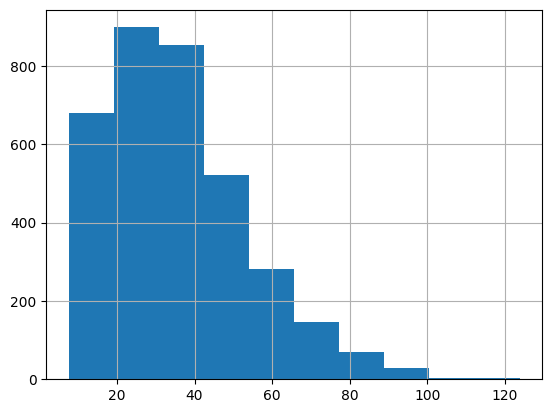

In [807]:
df_train['Anual_div_pitch_time'].hist()

In [808]:
# Á∑èÂêàÁöÑ„Å™Âñ∂Ê•≠Âäõ
df_train["total_pitch_point"] = df_train["NumberOfFollowups_max"] * (df_train["PitchSatisfactionScore"] + df_train["ProductPitched_Score"] + df_train["Pitch_minutes_0_med"])

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test["total_pitch_point"] = df_test["NumberOfFollowups_max"] * (df_test["PitchSatisfactionScore"] + df_test["ProductPitched_Score"] + df_test["Pitch_minutes_0_med"])

#
print(df_train["total_pitch_point"].value_counts())

total_pitch_point
60.0     221
48.0     169
80.0     141
72.0     132
56.0     126
        ... 
186.0      1
216.0      1
174.0      1
82.0       1
23.0       1
Name: count, Length: 123, dtype: int64


<Axes: >

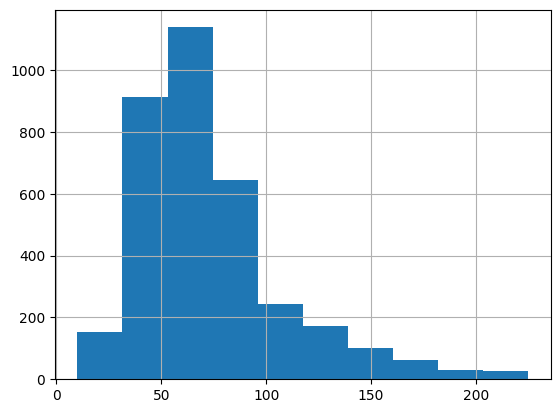

In [809]:
df_train["total_pitch_point"].hist()

<Axes: >

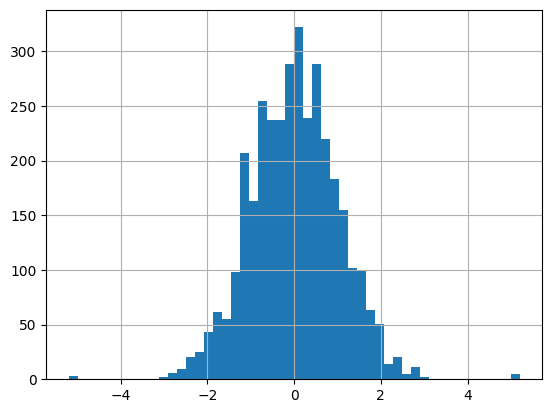

In [810]:
# RANKGAUSS„Ç™„Éñ„Ç∏„Çß„ÇØ„Éà„ÅÆ‰ΩúÊàê
qt = QuantileTransformer(n_quantiles=100, random_state=123, output_distribution='normal')

# df_train„Å∏„ÅÆÈÅ©Áî®
income_data_train = df_train[["total_pitch_point"]]
qt.fit(income_data_train)  # df_train„ÅÆ„Éá„Éº„Çø„Åßfit
df_train["total_pitch_transformed"] = qt.transform(income_data_train)

# df_test„Å∏„ÅÆÈÅ©Áî®
income_data_test = df_test[["total_pitch_point"]]
df_test["total_pitch_transformed"] = qt.transform(income_data_test)  # df_test„ÅÆ„Éá„Éº„Çø„ÇíÂ§âÊèõ

#
df_train["total_pitch_transformed"].hist(bins=50)

In [811]:
# Â£≤„ÇäËæº„ÅøÊ∫ÄË∂≥Â∫¶*È°ßÂÆ¢„É©„É≥„ÇØ=Ê∫ÄË∂≥Â∫¶„Å®È°ßÂÆ¢„É©„É≥„ÇØ„ÅåÈ´ò„ÅÑ„Åª„Å©ÊàêÁ¥ÑÁéá„ÇÇÈ´ò„ÅÑ„ÅÆ„Åß„ÅØ
df_train["RankSatisfaction"] = df_train["PitchSatisfactionScore"] * df_train["Designation_rank"].astype(int)

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test["RankSatisfaction"] = df_test["PitchSatisfactionScore"] * df_test["Designation_rank"].astype(int)

#
print(df_train["RankSatisfaction"].value_counts())

RankSatisfaction
4     664
2     632
6     580
12    362
3     351
8     275
9     263
1     189
16     70
20     33
10     26
15     23
5      21
Name: count, dtype: int64


In [812]:
# Â£≤„ÇäËæº„ÅøÊ∫ÄË∂≥Â∫¶*Âπ¥Âèé=È´ò„ÅÑÊï∞ÂÄ§„Å´„Å™„Åª„Å©ÊàêÁ¥Ñ„Åó„ÇÑ„Åô„ÅÑ„ÅÆ„Åß„ÅØ
df_train["Annual_satis_score"] = df_train["PitchSatisfactionScore"] * df_train["AnnualIncome_rounded"]

# df_test„Å∏„ÅÆÈÅ©Áî®
df_test["Annual_satis_score"] = df_test["PitchSatisfactionScore"] * df_test["AnnualIncome_rounded"]

#
print(df_train["Annual_satis_score"].value_counts())

Annual_satis_score
1440    81
720     69
960     44
1080    42
1648    38
        ..
353      1
1340     1
330      1
1707     1
334      1
Name: count, Length: 920, dtype: int64


<Axes: >

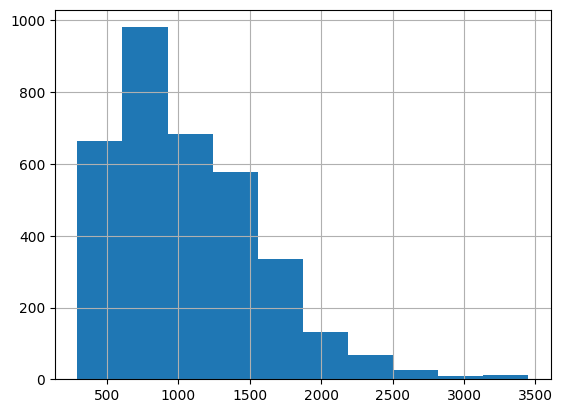

In [813]:
df_train["Annual_satis_score"].hist()

<Axes: >

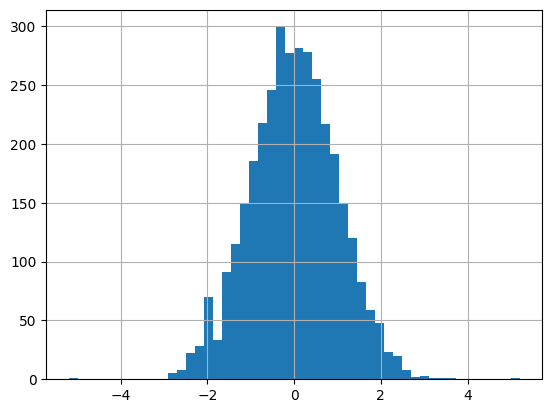

In [814]:
# RANKGAUSS„Ç™„Éñ„Ç∏„Çß„ÇØ„Éà„ÅÆ‰ΩúÊàê
qt = QuantileTransformer(n_quantiles=100, random_state=123, output_distribution='normal')

# df_train„Å∏„ÅÆÈÅ©Áî®
income_data_train = df_train[["Annual_satis_score"]]
qt.fit(income_data_train)  # df_train„ÅÆ„Éá„Éº„Çø„Åßfit
df_train["Annual_satis_transformed"] = qt.transform(income_data_train)

# df_test„Å∏„ÅÆÈÅ©Áî®
income_data_test = df_test[["Annual_satis_score"]]
df_test["Annual_satis_transformed"] = qt.transform(income_data_test)  # df_test„ÅÆ„Éá„Éº„Çø„ÇíÂ§âÊèõ

#
df_train["Annual_satis_transformed"].hist(bins=50)

In [815]:
df_train["Age_numeric_0_med"].describe()

count    3489.000000
mean       38.715391
std         9.818951
min        20.000000
25%        31.000000
50%        38.000000
75%        46.000000
max        60.000000
Name: Age_numeric_0_med, dtype: float64

In [816]:
df_train.isnull().sum()

id                          0
Age                         0
TypeofContact               6
CityTier                    0
DurationOfPitch             0
                           ..
total_pitch_point           0
total_pitch_transformed     0
RankSatisfaction            0
Annual_satis_score          0
Annual_satis_transformed    0
Length: 97, dtype: int64

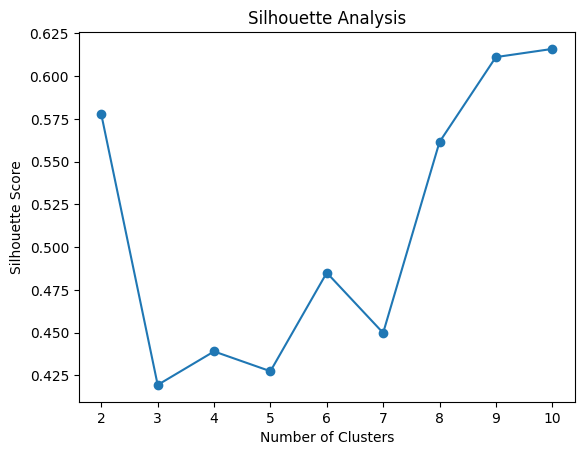

In [817]:
#„ÇØ„É©„Çπ„Çø„É™„É≥„Ç∞„Åß„Åç„Åù„ÅÜ„Å™Èñ¢‰øÇÊÄß„ÇíË¶ã„Å§„Åë„Çã
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# „ÇØ„É©„Çπ„ÇøÊï∞„ÇíÂ§âÂåñ„Åï„Åõ„Å™„Åå„Çâ„ÄÅ„Ç∑„É´„Ç®„ÉÉ„Éà‰øÇÊï∞„ÇíË®àÁÆó„ÅóÁ¢∫Ë™ç
silhouette_scores = []
for i in range(2, 11): # „ÇØ„É©„Çπ„ÇøÊï∞„ÅØ2‰ª•‰∏ä„Åß„Å™„ÅÑ„Å®Ë®àÁÆó„Åß„Åç„Å™„ÅÑ
    kmeans = KMeans(n_clusters=i, random_state=123)
    labels = kmeans.fit_predict(df_train[[
       "PitchSatisfactionScore",
            "ProductPitched_Score","Passport", "RankSatisfaction",]])
    silhouette_scores.append(silhouette_score(df_train[["PitchSatisfactionScore",
            "ProductPitched_Score","Passport", "RankSatisfaction",]], labels))

# „Ç∑„É´„Ç®„ÉÉ„Éà‰øÇÊï∞„Çí„Ç∞„É©„ÉïÂåñ
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

In [818]:
# „ÇØ„É©„Çπ„Çø„É™„É≥„Ç∞„Å´Áî®„ÅÑ„ÇãÁâπÂæ¥Èáè„ÇíÈÅ∏Êäû
features = ["PitchSatisfactionScore",
            "ProductPitched_Score","Passport", "RankSatisfaction"]

# ÁâπÂæ¥Èáè„ÇíÊ®ôÊ∫ñÂåñ
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_train[features])

# KMeans„Åß„ÇØ„É©„Çπ„Çø„É™„É≥„Ç∞ („ÇØ„É©„Çπ„ÇøÊï∞„Çí5„Å´Ë®≠ÂÆö)
kmeans = KMeans(n_clusters=10, random_state=123)
df_train['cluster_test'] = kmeans.fit_predict(scaled_features)

# „Ç∑„É´„Ç®„ÉÉ„Éà‰øÇÊï∞„ÇíË®àÁÆó
silhouette_avg = silhouette_score(scaled_features, df_train['cluster_test'])
print(f"Silhouette Score: {silhouette_avg}")

# „ÇØ„É©„Çπ„Çø„Åî„Å®„ÅÆÁâπÂæ¥Èáè„ÅÆÂπ≥ÂùáÂÄ§„ÇíË°®Á§∫
cluster_means = df_train.groupby('cluster_test')[features].mean()
print(cluster_means)

# „ÉÜ„Çπ„Éà„Éá„Éº„Çø„Å´„ÇÇÂêåÊßò„ÅÆÂá¶ÁêÜ„ÇíÈÅ©Áî®
scaled_features_test = scaler.transform(df_test[features]) # fit_transform „Åß„ÅØ„Å™„Åè transform „Çí‰ΩøÁî®
df_test['cluster_test'] = kmeans.predict(scaled_features_test)

Silhouette Score: 0.5658212555058868
              PitchSatisfactionScore  ProductPitched_Score  Passport  \
cluster_test                                                           
0                           2.345088              2.000000  0.000000   
1                           3.718894              1.213518  0.000000   
2                           2.324324              3.378378  1.000000   
3                           1.000000              1.603448  0.000000   
4                           2.237885              4.286344  0.000000   
5                           3.649289              3.011848  0.000000   
6                           2.422414              1.452586  1.000000   
7                           4.333333              4.428571  0.142857   
8                           2.008000              1.000000  0.000000   
9                           1.602254              3.133655  0.000000   

              RankSatisfaction  
cluster_test                    
0                     4.715365  

In [819]:
df_train['cluster_test'].value_counts()

cluster_test
1    651
9    621
5    422
0    397
8    375
3    348
6    232
4    227
2    111
7    105
Name: count, dtype: int64

In [820]:
df_train2 = df_train.copy()#lgbmÁî®„Å´„Ç≥„Éî„Éº
df_test2 = df_test.copy()#lgbmÁî®„Å´„Ç≥„Éî„Éº

In [821]:
#„Ç´„ÉÜ„Ç¥„É™Âûã„Å´Â§âÊèõ„Åô„Çã„Ç´„É©„É†„ÅÆ„É™„Çπ„Éà
category_cols =["TypeofContact_binary","TypeofContact_oe","CityTier_reverse","Gender_0","Passport", "material_count","PreferredPropertyStar",
                "car_status_count","child_info_cat",'MonthlyIncome_binned','Age_numeric_binned',"Occupation_oe",'cluster_test']




# „Ç´„ÉÜ„Ç¥„É™Âûã„Å´Â§âÊèõ
df_train2[category_cols] = df_train2[category_cols].astype('category')
df_test2[category_cols] = df_test2[category_cols].astype('category')

In [822]:
x_train2 = df_train2.drop(columns = ["ProdTaken", "id"])
y_train  = df_train2["ProdTaken"]
id_train = df_train2["id"]

In [823]:
print("mean: {:.4f}".format(y_train.mean()))
y_train.value_counts()

mean: 0.1424


ProdTaken
0.0    2992
1.0     497
Name: count, dtype: int64

In [824]:
cv = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=123).split(x_train2, y_train))

print("index(train):", cv[0][0])
print("index(valid):", cv[0][1])

index(train): [   1    2    3 ... 3484 3485 3487]
index(valid): [   0    4    7    8   22   25   40   45   46   50   51   54   59   60
   61   66   69   71   73   75   88   93   97  105  107  109  124  134
  135  138  144  149  158  161  162  174  177  184  187  191  198  202
  205  214  218  220  228  244  252  259  260  262  268  269  272  275
  286  292  302  304  310  317  320  330  345  366  371  376  380  386
  394  400  431  432  435  436  450  456  458  463  469  472  473  475
  478  484  514  524  529  534  536  537  540  545  547  557  561  579
  583  591  597  600  601  604  613  615  621  628  630  634  641  642
  644  647  654  667  671  679  684  692  693  695  697  701  715  722
  724  726  730  741  742  745  747  752  757  762  763  775  778  785
  786  790  795  796  799  835  836  841  844  846  856  857  859  863
  864  868  874  876  877  878  881  882  888  890  893  899  907  917
  930  938  939  941  952  954  955  959  960  973  974  978  980  984
  990  991  9

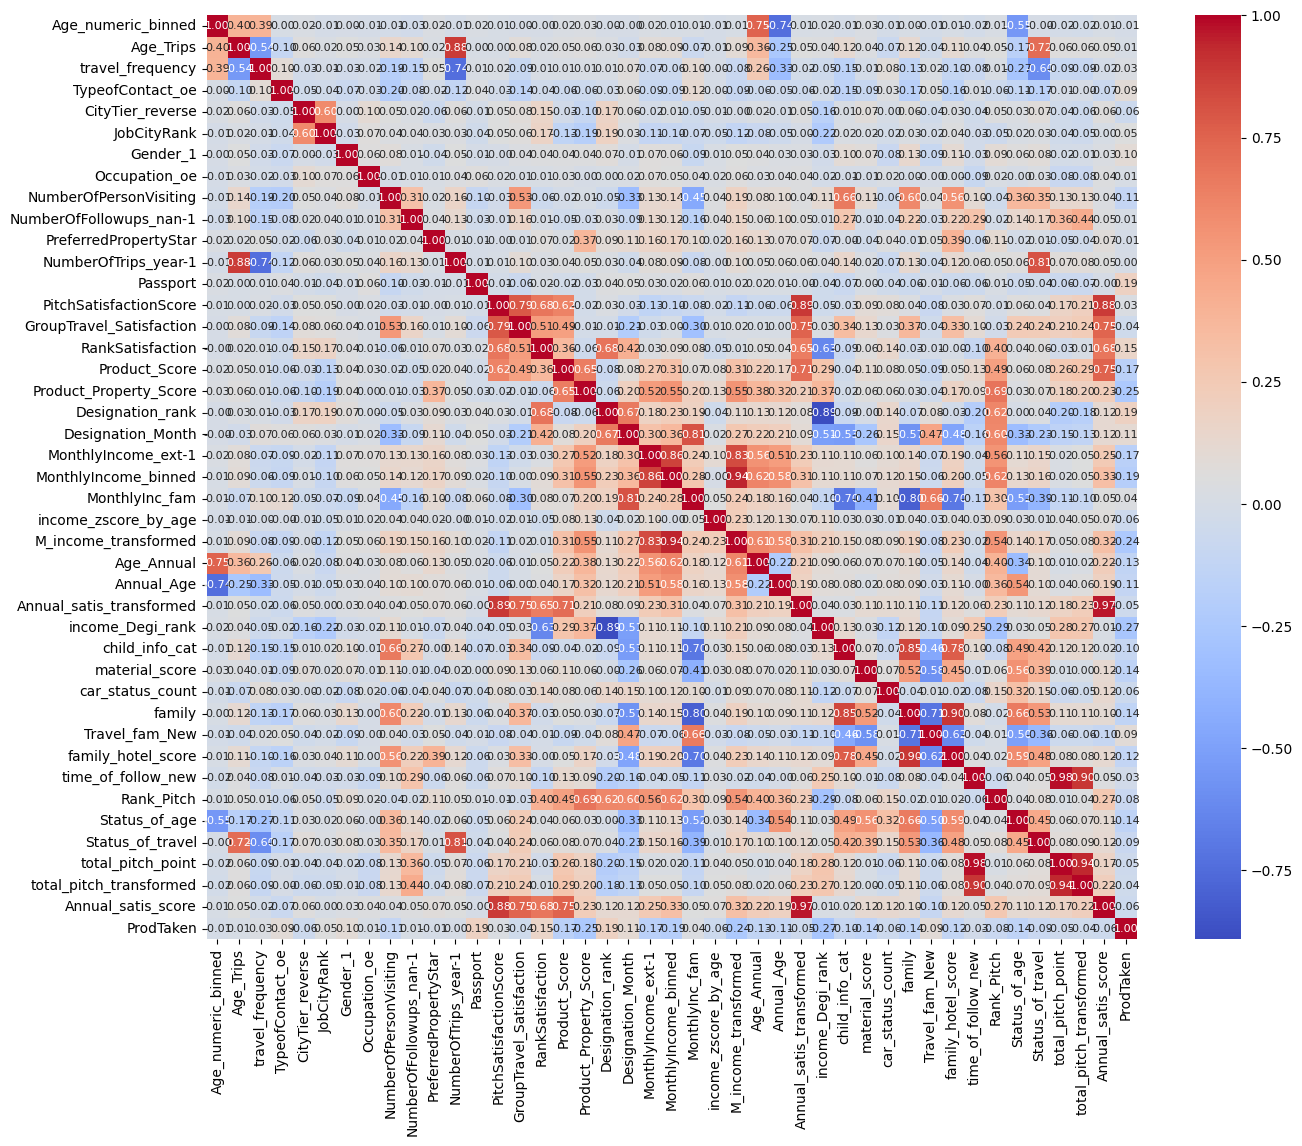

In [825]:
selected_cols = ["Age_numeric_binned","Age_Trips","travel_frequency","TypeofContact_oe","CityTier_reverse",
                     "JobCityRank","Gender_1", "Occupation_oe", "NumberOfPersonVisiting", "NumberOfFollowups_nan-1", "PreferredPropertyStar",
                     "NumberOfTrips_year-1","Passport", "PitchSatisfactionScore",
                     "GroupTravel_Satisfaction", "RankSatisfaction", "Product_Score", "Product_Property_Score",
                     "Designation_rank", "Designation_Month","MonthlyIncome_ext-1", "MonthlyIncome_binned", "MonthlyInc_fam",
                     "income_zscore_by_age", "M_income_transformed", "Age_Annual", "Annual_Age","Annual_satis_transformed",
                     "income_Degi_rank","child_info_cat", "material_score", "car_status_count","family",
                     "Travel_fam_New", "family_hotel_score", "time_of_follow_new", "Rank_Pitch", "Status_of_age", "Status_of_travel",
                      "total_pitch_point","total_pitch_transformed","Annual_satis_score","ProdTaken"]

# ÈÅ∏Êäû„Åó„Åü„Ç´„É©„É†„ÅßÁõ∏Èñ¢Ë°åÂàó„ÇíË®àÁÆó
corr_matrix = df_train[selected_cols].corr()

plt.figure(figsize=(15, 12))  # „Çµ„Ç§„Ç∫„ÇíÂ§ß„Åç„Åè
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 8})
plt.show()


In [826]:
 #„Éô„Éº„Çπ„É©„Ç§„É≥ÁâπÂæ¥ÈáèÈÅ∏Êäû
x_train = x_train2[["Age_numeric_binned","Age_Trips","travel_frequency","TypeofContact_oe","CityTier_reverse",
                     "JobCityRank","Gender_1", "Occupation_oe", "NumberOfPersonVisiting", "NumberOfFollowups_nan-1", "PreferredPropertyStar",
                     "NumberOfTrips_year-1", "Travel_Interval", "Passport", "PitchSatisfactionScore",
                     "GroupTravel_Satisfaction", "RankSatisfaction", "Product_Score", "Product_Property_Score",
                     "Designation_rank", "Designation_Month","MonthlyIncome_ext-1", "MonthlyIncome_binned", "MonthlyInc_fam",
                     "income_zscore_by_age", "M_income_transformed", "Age_Annual", "Annual_Age","Annual_satis_transformed",
                     "income_Degi_rank","child_info_cat", "material_score", "car_status_count","family",
                     "Travel_fam_New", "family_hotel_score", "time_of_follow_new", "Rank_Pitch", "Status_of_age", "Status_of_travel",
                      "total_pitch_point", "Annual_satis_score",]]

In [827]:
cv =  list(StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123).split(x_train, y_train))

nfold = 0
idx_tr, idx_va = cv[nfold][0], cv[nfold][1]

x_tr, y_tr, id_tr = x_train.loc[idx_tr, :], y_train[idx_tr], id_train[idx_tr]
x_va, y_va, id_va = x_train.loc[idx_va, :], y_train[idx_va], id_train[idx_va]

print(x_tr.shape, y_tr.shape, id_tr.shape)
print(x_va.shape, y_va.shape, id_va.shape)

(2791, 42) (2791,) (2791,)
(698, 42) (698,) (698,)


In [828]:
# „Éô„Éº„Çπ„É©„Ç§„É≥„Éë„É©„É°„Éº„Çø„ÅÆË®≠ÂÆö
params = {
"boosting_type" : "gbdt",
    "objective": "binary",
    "metric": "auc",
    "categorical_feature": ["TypeofContact_oe","Occupation_oe","CityTier_reverse","Gender_0","Passport","PreferredPropertyStar",
                "car_status_count","MonthlyIncome_binned","child_info_cat", "material_score",],
    "learning_rate": 1,
    "num_leaves": 64,
    'lambda_l1': 0.1,
    'lambda_l2': 20,
    "min_data_in_leaf": 50,
    "max_depth": 1,
    "n_estimators": 3000,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "subsample_freq": 2,
    "subsample": 0.7,
    "random_state": 123,
    "importance_type": "gain",
    "early_stopping_rounds": 100,
    "verbose": -1,
}

model_lgb_base = lgb.LGBMClassifier(**params)
model_lgb_base.fit(x_tr,y_tr,
          eval_set = [(x_tr, y_tr), (x_va, y_va)],)

with open("model_lgb_base_fold0.pickle", "wb") as f:
     pickle.dump(model_lgb_base, f, protocol=4)

In [829]:
x_tr_pred = model_lgb_base.predict_proba(x_tr)[:,1]
metric_tr = roc_auc_score(y_tr, x_tr_pred)

y_va_pred = model_lgb_base.predict_proba(x_va)[:,1]
metric_va = roc_auc_score(y_va, y_va_pred)

metrics = []

metrics.append([nfold, metric_tr, metric_va])

print("[auc] tr:{:.4f}, va:{:.4f}".format(metric_tr, metric_va))

[auc] tr:0.8635, va:0.8664


In [830]:
#OOF„ÅÆÊé®Ë´ñÂÄ§„ÇíÂÖ•„Çå„Çã
train_oof = np.zeros(len(x_train))
#Ê§úË®º„Éá„Éº„Çø„ÅÆindex„Å´Êé®Ë´ñÂÄ§„ÇíÊ†ºÁ¥ç
train_oof[idx_va] = y_va_pred

In [831]:
#ÈáçË¶ÅÂ∫¶„ÅÆÂèñÂæó
imp_fold = pd.DataFrame({"col": x_train.columns, "imp": model_lgb_base.feature_importances_, "nfold": nfold})
#Á¢∫Ë™ç‰∏ä10ÂÄã
display(imp_fold.sort_values("imp", ascending = False)[:40])

#ÈáçË¶ÅÂ∫¶„ÇíÊ†ºÁ¥ç„Åô„Çã5foldÁî®„Éá„Éº„Çø„Éï„É¨„Éº„É†„ÅÆ‰ΩúÊàê
imp = pd.DataFrame()
#imp_fold„Çí5foldÁî®„Éá„Éº„Çø„Éï„É¨„Éº„É†„Å´ÁµêÂêà
imp = pd.concat([imp, imp_fold])

col         imp  nfold
19          Designation_rank  186.770996      0
13                  Passport   61.823978      0
31            material_score   32.692402      0
4           CityTier_reverse   31.905871      0
22      MonthlyIncome_binned   27.023399      0
6                   Gender_1   24.791901      0
20         Designation_Month   22.801570      0
29          income_Degi_rank   21.269290      0
16          RankSatisfaction   17.483720      0
15  GroupTravel_Satisfaction   15.216980      0
18    Product_Property_Score   15.198670      0
26                Age_Annual   13.371440      0
21       MonthlyIncome_ext-1   12.472050      0
28  Annual_satis_transformed   11.758640      0
1                  Age_Trips   11.449560      0
36        time_of_follow_new   10.879390      0
38             Status_of_age   10.807280      0
39          Status_of_travel    8.968510      0
27                Annual_Age    7.947080      0
23            MonthlyInc_fam    7.654740      0
3           TypeofContact_oe    7.565290      0
0         Age_numeric_binned    4.971920      0
2           travel_frequency    4.655270      0
34            Travel_fam_New    4.513090      0
10     PreferredPropertyStar    3.753590      0
32          car_status_count    3.719850      0
12           Travel_Interval    3.708380      0
14    PitchSatisfactionScore    3.146110      0
11      NumberOfTrips_year-1    2.537360      0
41        Annual_satis_score    2.237060      0
24      income_zscore_by_age    1.905370      0
30            child_info_cat    0.000000      0
8     NumberOfPersonVisiting    0.000000      0
9    NumberOfFollowups_nan-1    0.000000      0
33                    family    0.000000      0
25      M_income_transformed    0.000000      0
35        family_hotel_score    0.000000      0
7              Occupation_oe    0.000000      0
37                Rank_Pitch    0.000000      0
5                JobCityRank    0.000000      0

In [832]:
#„É™„Çπ„ÉàÂûã„ÇíarrayÂûã„Å´Â§âÊèõ
metrics = np.array(metrics)
print(metrics)

#Â≠¶ÁøíÊ§úË®º„Éá„Éº„Çø„ÅÆË©ï‰æ°ÂÄ§„ÅÆÂπ≥ÂùáÂÄ§„Å®Ê®ôÊ∫ñÂÅèÂ∑Æ„ÇíÁÆóÂá∫
print("[cv] tr:{:.4f}+-{:.4f}, va:{:.4f}+-{:.4f}".format(
  metrics[:, 1].mean(), metrics[:,1].std(),
  metrics[:, 2].mean(), metrics[:, 2].std(),))

#oof„ÅÆË©ï‰æ°ÂÄ§„ÇíÁÆóÂá∫
print("[oof] tr:{:.4f}".format(roc_auc_score(y_train, train_oof)))

[[0.         0.86350532 0.8664214 ]]
[cv] tr:0.8635+-0.0000, va:0.8664+-0.0000
[oof] tr:0.5154


In [833]:
train_oof = pd.concat([
    id_train,pd.DataFrame({"true": y_train, "pred": train_oof}),
], axis = 1)
train_oof.head()

id  true      pred
0   0   1.0  0.938143
1   1   0.0  0.000000
2   2   1.0  0.000000
3   3   0.0  0.000000
4   4   1.0  0.664641

In [834]:
imp = imp.groupby("col")["imp"].agg(["mean", "std"]).reset_index(drop = False)
imp.columns = ["col", "imp", "imp_std"]
imp.head()

col       imp  imp_std
0          Age_Annual  13.37144      NaN
1           Age_Trips  11.44956      NaN
2  Age_numeric_binned   4.97192      NaN
3          Annual_Age   7.94708      NaN
4  Annual_satis_score   2.23706      NaN

In [835]:
def train_lgb(input_x,
             input_y,
             input_id,
             params,
             list_nfold = [0, 1, 2, 3, 4,],
             n_splits = 5,):
    train_oof2 = np.zeros(len(input_x))
    metrics = []
    imp = pd.DataFrame()

    #cross-validation„ÅØfold4„Å®fold5„Å∏„ÅÆÂàÜÂâ≤„ÅÆ„Éê„É©„É≥„Çπ„ÅåÊÇ™„Åã„Å£„Åü„Åü„ÇÅ„ÄÅStratifiedGroupKFold„Å∏Â§âÊõ¥
    cv = list(StratifiedGroupKFold(n_splits = n_splits, shuffle = True, random_state = 123).
        split(input_x, input_y, groups= df_train2["Age_numeric_0_med"].values))
    for nfold in list_nfold:
        print("-"*20,nfold in list_nfold, "-"*20)

    #make dataset
        idx_tr, idx_va = cv[nfold][0],cv[nfold][1]
        x_tr, y_tr, id_tr = input_x.loc[idx_tr, :], input_y[idx_tr], input_id.iloc[idx_tr]
        x_va, y_va, id_va = input_x.loc[idx_va, :], input_y[idx_va], input_id.iloc[idx_va]
        print(x_tr.shape, x_va.shape)

        #train
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(x_tr,
             y_tr,
             eval_set = [(x_tr, y_tr), (x_va, y_va)],)
             #early_stopping_rounds = 100,
             #verbose = 100
        fname_lgb = "model_lgb_fold{}.pickle".format(nfold)
        with open(fname_lgb, "wb") as f:
            pickle.dump(model_lgb, f, protocol =4)
        #evaluate
        y_tr_pred = model_lgb.predict_proba(x_tr)[:,1]
        y_va_pred = model_lgb.predict_proba(x_va)[:,1]
        metric_tr = roc_auc_score(y_tr, y_tr_pred)
        metric_va = roc_auc_score(y_va, y_va_pred)
        metrics.append([nfold, metric_tr, metric_va])
        print("[auc] tr:{:.4f}, va:{:.4f}".format(metric_tr, metric_va))

        #oof
        train_oof2[idx_va] = y_va_pred

        #imp
        _imp = pd.DataFrame({"col":input_x.columns, "imp":model_lgb.feature_importances_,
                        "nfold":nfold})
        imp = pd.concat([imp, _imp])

    print("-"*20, "result", "-"*20)
    # metric
    metrics = np.array(metrics)
    print(metrics)
    print("[cv]tr:{:.4f}+-{:.4f}, va:{:.4f}+-{:.4f}".format(
    metrics[:,1].mean(), metrics[:,1].std(),
    metrics[:,2].mean(), metrics[:,2].std(),))
    print("[oof] {:.4f}".format(
    roc_auc_score(input_y, train_oof2)))

    #oof
    train_oof2 = pd.concat([
        input_id,
        pd.DataFrame({"pred": train_oof2})],axis = 1)
    #importance
    imp = imp.groupby("col")["imp"].agg(["mean", "std"]).reset_index(drop=False)
    imp.columns = ["col", "imp", "imp_std"]

    return train_oof2, imp, metrics

In [836]:
#„Éë„É©„É°„Éº„Çø„Éº„ÉÅ„É•„Éº„Éã„É≥„Ç∞„Å®ÂÆüË°å
params = {
    "boosting_type" : "gbdt",
    "objective": "binary",
    "metric": "auc",
    "categorical_feature": ['CityTier_reverse','Passport','cluster_test',"TypeofContact_oe","CityTier_reverse","Gender_0",
                       "Occupation_oe", "child_info_int", "material_count",],
    #"class_weight": "balanced",
   "learning_rate": 1,
    "num_leaves": 32,
    'lambda_l1': 1,
    'lambda_l2': 30,
    "min_data_in_leaf": 20,
    "max_depth": 1,
    "n_estimators": 5000,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "subsample_freq": 2,
    "subsample": 0.7,
    "random_state": 123,
    "importance_type": "gain",
    "early_stopping_rounds": 30,
    "verbose": -1,}


#Â≠¶Áøí„ÅÆÂÆüË°å
train_oof2, imp, metrics = train_lgb(x_train,
                                   y_train,
                                   id_train,
                                   params,
                                   list_nfold = [0,1,2,3,4],
                                   n_splits = 5,
                                   )

-------------------- True --------------------
(2742, 42) (747, 42)
[auc] tr:0.8480, va:0.8552
-------------------- True --------------------
(2744, 42) (745, 42)
[auc] tr:0.8725, va:0.8174
-------------------- True --------------------
(2896, 42) (593, 42)
[auc] tr:0.8421, va:0.8294
-------------------- True --------------------
(2764, 42) (725, 42)
[auc] tr:0.8353, va:0.8237
-------------------- True --------------------
(2810, 42) (679, 42)
[auc] tr:0.8753, va:0.8441
-------------------- result --------------------
[[0.         0.84796465 0.85522341]
 [1.         0.87248637 0.8173531 ]
 [2.         0.84207039 0.82935728]
 [3.         0.83531893 0.8237147 ]
 [4.         0.87527094 0.84413649]]
[cv]tr:0.8546+-0.0162, va:0.8340+-0.0138
[oof] 0.8335


In [837]:
train_oof2.head()

id      pred
0   0  0.788698
1   1  0.250987
2   2  0.389779
3   3  0.045925
4   4  0.536423

In [838]:
imp.sort_values("imp", ascending = False)[:40]

col         imp    imp_std
23    Product_Property_Score  179.584631   9.828079
20                  Passport   50.227768  11.066955
38            material_score   35.414560  11.690871
6           CityTier_reverse   27.521630   7.821934
12      M_income_transformed   26.617548  20.064994
36          income_Degi_rank   19.270664  23.963104
9                   Gender_1   16.966612   1.927476
7          Designation_Month   10.827290   6.461282
25          RankSatisfaction   10.171618   8.708458
1                  Age_Trips    9.274956   9.383716
29           Travel_Interval    8.191450   4.820455
14      MonthlyIncome_binned    7.573612  14.651932
5   Annual_satis_transformed    6.610280   4.833176
31          TypeofContact_oe    6.307488   0.852131
27             Status_of_age    6.073800   6.439278
0                 Age_Annual    5.661318   8.419372
2         Age_numeric_binned    5.425980   7.630438
8           Designation_rank    4.591774   9.001477
40         total_pitch_point    4.179768   4.484414
39        time_of_follow_new    4.120520   6.549861
22     PreferredPropertyStar    4.116432   2.656642
41          travel_frequency    3.692612   3.883380
3                 Annual_Age    3.408204   3.766360
32          car_status_count    3.114916   2.913623
13            MonthlyInc_fam    2.848738   3.068118
28          Status_of_travel    2.834264   4.157808
18      NumberOfTrips_year-1    2.640264   3.819919
37      income_zscore_by_age    2.383228   3.988643
35        family_hotel_score    2.122100   4.745160
24             Product_Score    1.782152   2.072383
10  GroupTravel_Satisfaction    1.635182   3.656378
15       MonthlyIncome_ext-1    1.391842   2.119138
30            Travel_fam_New    1.019118   1.397874
26                Rank_Pitch    0.608574   1.360813
4         Annual_satis_score    0.536536   1.199731
11               JobCityRank    0.518506   1.159415
17    NumberOfPersonVisiting    0.425540   0.951536
19             Occupation_oe    0.415908   0.929999
16   NumberOfFollowups_nan-1    0.365640   0.817596
34                    family    0.000000   0.000000

In [839]:
#„ÉÜ„Çπ„Éà„Éá„Éº„Çø„Å∏„ÅÆÊé®Ë´ñ„ÄÅ„Éá„Éº„Çø„Çª„ÉÉ„Éà‰ΩúÊàê
x_test2 = df_test2.drop(columns = ["ProdTaken","id"])
id_test = df_test2["id"]

In [840]:
#x_test „Å´ÂØæ„Åó„Å¶ÁâπÂæ¥ÈáèÈÅ∏Êäû
x_test2 = x_train[["Age_numeric_binned","Age_Trips","travel_frequency","TypeofContact_oe","CityTier_reverse",
                     "JobCityRank","Gender_1", "Occupation_oe", "NumberOfPersonVisiting", "NumberOfFollowups_nan-1", "PreferredPropertyStar",
                     "NumberOfTrips_year-1", "Travel_Interval", "Passport", "PitchSatisfactionScore",
                     "GroupTravel_Satisfaction", "RankSatisfaction", "Product_Score", "Product_Property_Score",
                     "Designation_rank", "Designation_Month","MonthlyIncome_ext-1", "MonthlyIncome_binned", "MonthlyInc_fam",
                     "income_zscore_by_age", "M_income_transformed", "Age_Annual", "Annual_Age","Annual_satis_transformed",
                     "income_Degi_rank","child_info_cat", "material_score", "car_status_count","family",
                     "Travel_fam_New", "family_hotel_score", "time_of_follow_new", "Rank_Pitch", "Status_of_age", "Status_of_travel",
                      "total_pitch_point", "Annual_satis_score",]]

In [841]:
with open("model_lgb_base_fold0.pickle", "rb") as f:
    model_lgb_base = pickle.load(f)

In [842]:
#Êé®Ë´ñ
test_pred_fold = model_lgb_base.predict_proba(x_test2)[:,1]

#Êé®Ë´ñÂÄ§„ÇíÊ†ºÁ¥ç„Åô„ÇãÂ§âÊï∞„Çí‰ΩúÊàê
test_pred = np.zeros((len(x_test2), 5))

#1-foldÁõÆ„ÅÆÊé®Ë´ñÂÄ§„ÇíÊ†ºÁ¥ç
test_pred[:, 0] = test_pred_fold

In [843]:
#ÂêÑfold„ÅÆÊé®Ë´ñÂÄ§„ÅÆÂπ≥ÂùáÂÄ§„ÇíÁÆóÂá∫
test_pred_mean = test_pred.mean(axis = 1)

#Êé®Ë´ñÂÄ§„ÅÆ„Éá„Éº„Çø„Éï„É¨„Éº„É†„Çí‰ΩúÊàê
df_test_pred = pd.concat([
id_test,
pd.DataFrame({"pred" :test_pred_mean}),
],axis = 1)
df_test_pred.head()

id      pred
0  3489  0.187629
1  3490  0.032789
2  3491  0.048865
3  3492  0.015423
4  3493  0.132928

In [844]:
#Êé®Ë´ñÈñ¢Êï∞„ÅÆÂÆöÁæ©

def predict_lgb(input_x,
               input_id,
               list_nfold = [0,1, 2, 3, 4],
               ):
    pred = np.zeros((len(input_x), len(list_nfold)))
    for nfold in list_nfold:
        print("-"*20, nfold, "-"*20)
        fname_lgb = "model_lgb_fold{}.pickle".format(nfold)
        with open(fname_lgb, "rb") as f:
            model1 = pickle.load(f)
        pred[:, nfold] = model1.predict_proba(input_x)[:,1]

    pred = pd.concat([
        input_id,
        pd.DataFrame({"pred": pred.mean(axis = 1)}),
    ], axis = 1)

    print("Done.")

    return pred

In [845]:
test_pred2 = predict_lgb(x_test2, id_test,
                       list_nfold = [0, 1, 2, 3, 4],)

-------------------- 0 --------------------
-------------------- 1 --------------------
-------------------- 2 --------------------
-------------------- 3 --------------------
-------------------- 4 --------------------
Done.


In [846]:
test_pred2.head()

id      pred
0  3489  0.870809
1  3490  0.141086
2  3491  0.221175
3  3492  0.064680
4  3493  0.554873

In [847]:
df_submit_lgb_base = pd.read_csv("/content/drive/MyDrive/SIGNATE-travel/sample_submit.csv", header = None)
df_submit_lgb_base.tail()

0         1
3484  6973  0.119451
3485  6974  0.119451
3486  6975  0.119451
3487  6976  0.119451
3488  6977  0.119451

In [848]:
df_submit_lgb_base[1] = test_pred2["pred"]


#df_submit = test_pred.rename(columns = {"pred": "TARGET"})
print(df_submit_lgb_base.shape)
display(df_submit_lgb_base.head())

#„Éï„Ç°„Ç§„É´Âá∫Âäõ(„Éô„Éº„Çπ„É©„Ç§„É≥submit)
#df_submit_lgb.to_csv("Travel2_submit_62.csv", index = None)

(3489, 2)


0         1
0  3489  0.870809
1  3490  0.141086
2  3491  0.221175
3  3492  0.064680
4  3493  0.554873

In [849]:
df_train2.info(verbose  = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 98 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   id                        3489 non-null   int64   
 1   Age                       3489 non-null   category
 2   TypeofContact             3483 non-null   category
 3   CityTier                  3489 non-null   int64   
 4   DurationOfPitch           3489 non-null   category
 5   Occupation                3489 non-null   category
 6   Gender                    3489 non-null   category
 7   NumberOfPersonVisiting    3489 non-null   float64 
 8   NumberOfFollowups         3456 non-null   float64 
 9   ProductPitched            3489 non-null   category
 10  PreferredPropertyStar     3489 non-null   category
 11  NumberOfTrips             3489 non-null   category
 12  Passport                  3489 non-null   category
 13  PitchSatisfactionScore    3489 non-null   int64 

In [850]:
#ÁâπÂæ¥ÈáèÈÅ∏Êäû
df_train3 = df_train2[["TypeofContact_oe","CityTier_reverse","Designation_rank","family",
"Gender_0","NumberOfPersonVisiting","NumberOfFollowups_max","income_zscore_by_age","Age_Annual","AnnualIncome_rounded",
"ProductPitched_Score","PitchSatisfactionScore","Product_Score","Passport", "material_count","child_info_int","NumberOfTrips_year",
"PreferredPropertyStar","time_of_follow_new","car_status_count","Travel_fam_New","travel_frequency","Rank_Pitch","Status_of_travel",
                    "Occupation_rank", "JobCityRank", "GroupTravel_Satisfaction","M_income_transformed","Age_ann_transformed", "Age_nume_transformed",
                      'RankSatisfaction', 'cluster_test',]]

In [851]:
x_train2 = df_train3
y_train  = df_train2["ProdTaken"]
id_train = df_train2["id"]

In [852]:
#Â≠¶Áøí„ÅÆÂÆüË°å
train_oof2, imp, metrics = train_lgb(x_train2,
                                   y_train,
                                   id_train,
                                   params,
                                   list_nfold = [0,1,2,3,4],
                                   n_splits = 5,
                                   )

-------------------- True --------------------
(2742, 32) (747, 32)
[auc] tr:0.8486, va:0.8598
-------------------- True --------------------
(2744, 32) (745, 32)
[auc] tr:0.8513, va:0.8108
-------------------- True --------------------
(2896, 32) (593, 32)
[auc] tr:0.8436, va:0.8284
-------------------- True --------------------
(2764, 32) (725, 32)
[auc] tr:0.8326, va:0.8301
-------------------- True --------------------
(2810, 32) (679, 32)
[auc] tr:0.8535, va:0.8336
-------------------- result --------------------
[[0.         0.84862651 0.85976193]
 [1.         0.85127524 0.81078588]
 [2.         0.84358675 0.82837496]
 [3.         0.8326109  0.83011885]
 [4.         0.85350972 0.83358457]]
[cv]tr:0.8459+-0.0074, va:0.8325+-0.0157
[oof] 0.8330


In [853]:
imp.sort_values("imp", ascending = False)[:40]

col         imp    imp_std
17      ProductPitched_Score  174.534799  14.632370
26              cluster_test   46.696771  20.102993
3       AnnualIncome_rounded   44.714332   5.792701
14                  Passport   35.941882  19.463579
29            material_count   35.146760  11.741313
4           CityTier_reverse   28.147332   4.437395
6                   Gender_0   15.794920   2.467758
12        NumberOfTrips_year    8.576892   5.852481
30        time_of_follow_new    5.995280   6.050101
23          TypeofContact_oe    5.743146   3.625254
16     PreferredPropertyStar    4.121052   3.058288
0                 Age_Annual    3.807918   4.963731
7   GroupTravel_Satisfaction    3.704960   2.540298
31          travel_frequency    3.516312   4.091604
24          car_status_count    2.937202   1.889910
5           Designation_rank    2.853922   2.133190
28      income_zscore_by_age    2.815452   3.940674
2       Age_nume_transformed    2.558616   2.646940
19          RankSatisfaction    2.163284   3.395423
21          Status_of_travel    2.119872   2.003484
18             Product_Score    1.394994   2.089444
8                JobCityRank    1.065202   1.549770
1        Age_ann_transformed    0.501842   1.122153
13           Occupation_rank    0.455260   1.017992
10     NumberOfFollowups_max    0.385006   0.860900
9       M_income_transformed    0.339424   0.758975
27                    family    0.000000   0.000000
11    NumberOfPersonVisiting    0.000000   0.000000
25            child_info_int    0.000000   0.000000
20                Rank_Pitch    0.000000   0.000000
15    PitchSatisfactionScore    0.000000   0.000000
22            Travel_fam_New    0.000000   0.000000

In [854]:
#x_test „Å´ÂØæ„Åó„Å¶ÁâπÂæ¥ÈáèÈÅ∏Êäû
x_test3 = df_test2[["TypeofContact_oe","CityTier_reverse","Designation_rank","family",
"Gender_0","NumberOfPersonVisiting","NumberOfFollowups_max","income_zscore_by_age","Age_Annual","AnnualIncome_rounded",
"ProductPitched_Score","PitchSatisfactionScore","Product_Score","Passport", "material_count","child_info_int","NumberOfTrips_year",
"PreferredPropertyStar","time_of_follow_new","car_status_count","Travel_fam_New","travel_frequency","Rank_Pitch","Status_of_travel",
                    "Occupation_rank", "JobCityRank", "GroupTravel_Satisfaction","M_income_transformed","Age_ann_transformed", "Age_nume_transformed",
                    'RankSatisfaction', 'cluster_test',]]

In [855]:
#Êé®Ë´ñÈñ¢Êï∞„ÅÆÂÆüË°å

def predict_lgb3(input_x,
               input_id,
               list_nfold = [0,1, 2, 3, 4],
               ):
    pred = np.zeros((len(input_x), len(list_nfold)))
    for nfold in list_nfold:
        print("-"*20, nfold, "-"*20)
        fname_lgb = "model_lgb_fold{}.pickle".format(nfold)
        with open(fname_lgb, "rb") as f:
            model1 = pickle.load(f)
        pred[:, nfold] = model1.predict_proba(input_x)[:,1]

    pred = pd.concat([
        input_id,
        pd.DataFrame({"pred": pred.mean(axis = 1)}),
    ], axis = 1)

    print("Done.")

    return pred

In [856]:
test_pred3 = predict_lgb3(x_test3, id_test,
                       list_nfold = [0, 1, 2, 3, 4],)

-------------------- 0 --------------------
-------------------- 1 --------------------
-------------------- 2 --------------------
-------------------- 3 --------------------
-------------------- 4 --------------------
Done.


In [857]:
test_pred3.head()

id      pred
0  3489  0.100035
1  3490  0.209965
2  3491  0.180354
3  3492  0.529878
4  3493  0.366559

In [858]:
df_submit_lgb = pd.read_csv("/content/drive/MyDrive/SIGNATE-travel/sample_submit.csv", header = None)
df_submit_lgb.tail()

0         1
3484  6973  0.119451
3485  6974  0.119451
3486  6975  0.119451
3487  6976  0.119451
3488  6977  0.119451

In [859]:
df_submit_lgb[1] = test_pred3["pred"]


print(df_submit_lgb.shape)
display(df_submit_lgb.head())

#„Éï„Ç°„Ç§„É´Âá∫Âäõ(„Çπ„Çø„ÉÉ„Ç≠„É≥„Ç∞Ââç„Å´Â§â„Åà„Å¶„Åó„Åæ„Å£„Åü„Åã„ÇÇ„Åó„Çå„Å™„ÅÑ„Ååre„Çí„Å§„Åë„Åü„ÇÇ„ÅÜ„ÅÑ„Å°„Å©)
# df_submit_lgb.to_csv("Travel2_submit_re75.csv", index = None)
#ÈÄî‰∏≠„Åã„ÇâË™≠„ÅøÁõ¥„Åó„Åü„ÇÇ„ÅÆ„Çíre75„Å®„Åó„Å¶„Åó„Åæ„Å£„Å¶„ÅÑ„Åü„Åü„ÇÅ„ÄÅÊúÄÂàù„Åã„ÇâË™≠„ÅøÁõ¥„Åó„Å¶75(1„Å®„Åó„Åü)
#df_submit_lgb.to_csv("Travel2_submit_test16.csv", index = None)

(3489, 2)


0         1
0  3489  0.100035
1  3490  0.209965
2  3491  0.180354
3  3492  0.529878
4  3493  0.366559